In [1208]:
import numpy as np 
import pandas as pd 

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno

import sqlite3 as sql 

import pingouin as pg
from random import sample

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [1201]:
import warnings
warnings.filterwarnings('ignore')

- The european soccer database is about soccer matches from 2008 to 2016, consist of players' attributes, countries, teams' attributes, and match information.

In [23]:
def my_histogram(df, column_name):
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex = True, gridspec_kw = {"height_ratios": (.2, .8)}, figsize = (10, 7))

    sns.boxplot(x = df[column_name], ax = ax_box, showfliers = False)
    sns.histplot(x = df[column_name], ax = ax_hist, kde = True)

    plt.grid()
    plt.xlabel(column_name, fontsize = 16)
    plt.ylabel("Count", fontsize = 16)
    ax_box.set_xlabel("")

    plt.show()

# 1. Load and overview the data

In [24]:
con = sql.connect("database.sqlite")

In [25]:
pd.set_option('display.max_columns', None)

In [26]:
sql_master_tables = pd.read_sql('select * from sqlite_master where type="table";',con)
sql_master_tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [27]:
pd.read_sql(
    "select * from sqlite_sequence", con
    )

,name,seq
0,Team,103916
1,Country,51958
2,League,51958
3,Match,51958
4,Player,11075
5,Player_Attributes,183978
6,Team_Attributes,1458


- There are 7 tables.
    - Player related data
        - Player table
        - Player_Attributes table
    - Team related data
        - Country table
        - League table
        - Team table
        - Team_Attributes table
    - Match related ata
        - Match table

## 1.1. Player related data

### 1.1.1. Player table

In [88]:
df_player = pd.read_sql(
    "select * from Player", con
    )

df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [29]:
df_player.shape

(11060, 7)

In [30]:
len(df_player.player_api_id.unique())

11060

In [31]:
len(df_player.player_fifa_api_id.unique())

11060

In [32]:
sum(df_player.groupby(["player_api_id","player_fifa_api_id"]).count().id != 1)

0

- There are total 11,060 soccer players and their birthday, height, weight information.
- Each player has exactly one player_api_id, one player_fifa_api_id, and one (player_api_id, player_fifa_api_id) set. So, we can use any player id to identify a player.

In [33]:
df_player.isna().sum()

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64

- There is no missing value in the Player table.

### 1.1.2. Player_attributes table

In [89]:
df_player_attr = pd.read_sql(
    "select * from Player_Attributes", con
    )

df_player_attr.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [35]:
df_player_attr.shape

(183978, 42)

- There are total 38 player attributes.

In [36]:
player_num_collected = pd.DataFrame(df_player_attr.groupby("player_api_id").count().id)
player_num_collected.columns = ["num_collected"]
player_num_collected

,num_collected
player_api_id,
2625,14
2752,21
2768,21
2770,15
2790,5
...,...
744907,11
746419,2
748432,2


In [37]:
df_player_attr.groupby("player_api_id").count().id.describe()

count    11060.000000
mean        16.634539
std          9.395639
min          2.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         56.000000
Name: id, dtype: float64

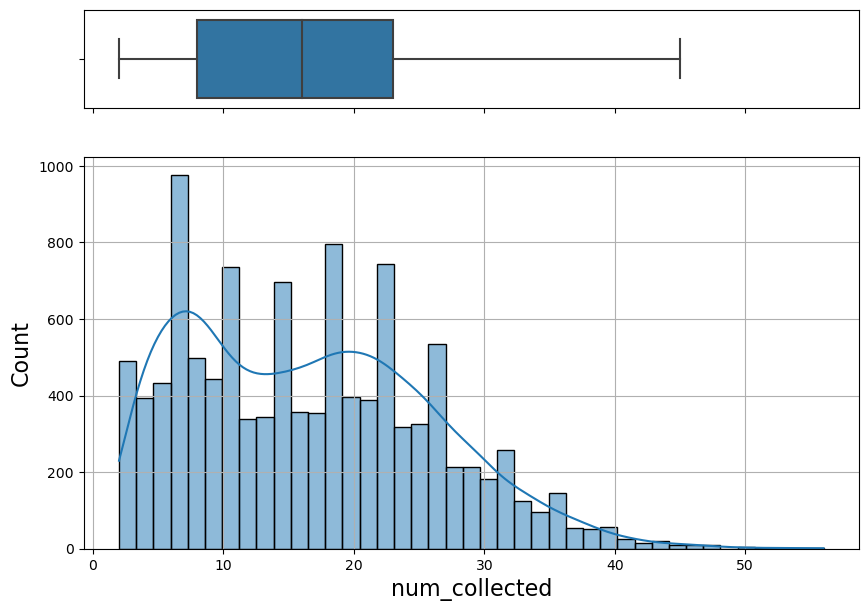

In [38]:
my_histogram(player_num_collected, "num_collected")

- Players' attributes are collected in different days.
- The player's characteristic data was collected 2 times for the fewest players and 56 times for the most players.
- I think we should use player attributes collected closest to match days.
- If the attributes don't change much, it seems possible to use summary statistics such as averages of attributes collected on different days for each player.


In [39]:
df_player_attr.isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

<AxesSubplot:>

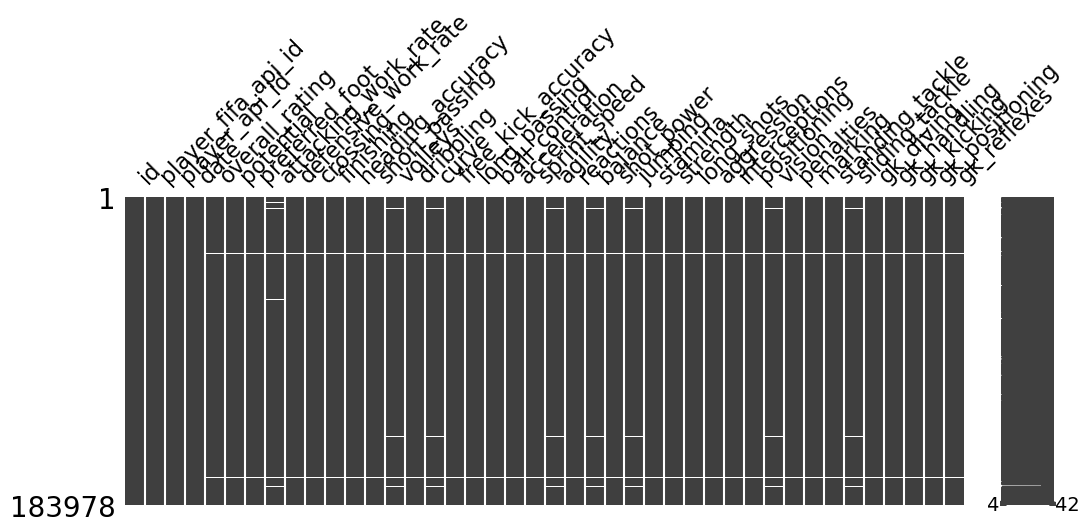

In [40]:
msno.matrix(df = df_player_attr, figsize = (12, 4))

- It looks like there are some patterns in missing values of the player attributes.
- If overall_rating is missing, then all other attributes are missing. This cases are only 0.4% (832 / 183978) of total data, so we can just drop this missing values later.
- There are cases where only some of the attributes have missing values. These cases should be considered later wheter to do impute appropriate values or drop.

## 1.2. Team related data

### 1.2.1. Country table

In [41]:
df_country = pd.read_sql(
    "select * from Country", con
    )

df_country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


- There are total 11 countries

### 1.2.2. League table

In [42]:
df_league = pd.read_sql(
    "select * from League", con
    )

df_league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


- There are total 11 leagues from different countries.
- Since there is only one league per country, country and league represent the same information.

### 1.2.3. Team table

In [43]:
df_team = pd.read_sql(
    "select * from Team", con
    )

df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [44]:
df_team.shape

(299, 5)

In [45]:
len(df_team.team_api_id.unique())

299

In [46]:
len(df_team.team_fifa_api_id.unique())

286

In [47]:
df_team.isna().sum()

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64

- team_api_id and team_fifa_api_id have different length because team_fifa_api_id has 11 missing values.
- So it is better to use team_api rather than use team_fifa_api_id to identify teams.
- There are 299 teams.

### 1.2.4. Team_Attributes table

In [48]:
df_team_attr = pd.read_sql(
    "select * from Team_Attributes", con
    )

df_team_attr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [49]:
df_team_attr.shape

(1458, 25)

- There are 21 team attributes.

In [50]:
len(df_team_attr.team_api_id.unique())

288

- The number of teams that have team attributes are 288 out of total 299 teams. 
- This is because the team attributes were collected by team_fifa_api_id, which has 11 missing values.
- Team attributes are important features, so I think matches of teams without team attributes should be excluded from the analysis.

In [51]:
team_num_collected = pd.DataFrame(df_team_attr.groupby("team_api_id").count().id)
team_num_collected.columns = ["num_collected"]
team_num_collected

,num_collected
team_api_id,
1601,6
1773,3
1957,6
2033,5
2182,6
...,...
10281,6
108893,6
158085,2


In [52]:
team_num_collected.describe()

,num_collected
count,288.000000
mean,5.062500
std,1.540255
min,1.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,6.000000


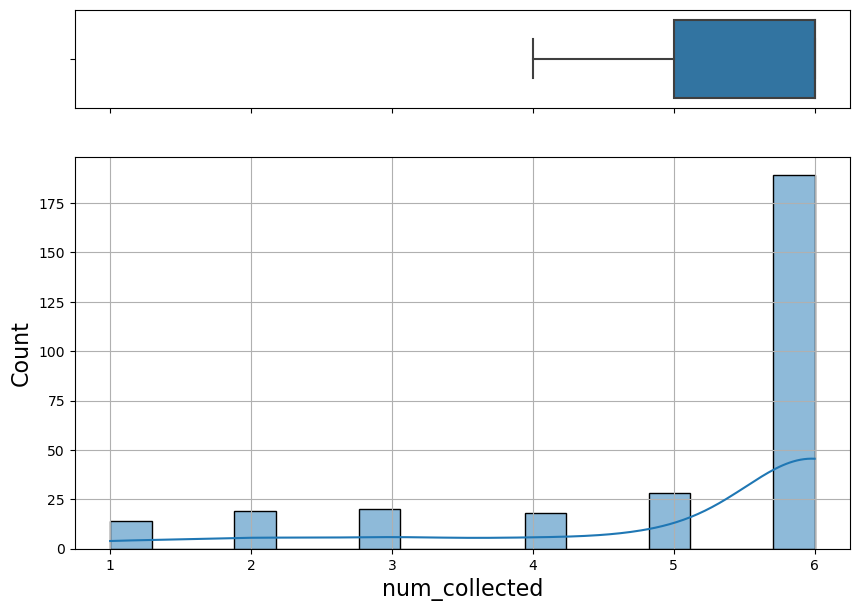

In [53]:
my_histogram(team_num_collected, "num_collected")

- For most teams, team attributes were collected 5 to 6 times.
- I think we should use team attributes collected closest to match days.
- If the attributes don't change much, it seems possible to use summary statistics such as averages of attributes collected on different days for each team.


In [54]:
df_team_attr.isna().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

In [55]:
df_team_attr.shape

(1458, 25)

- There are no missing values for team attributes except for the buildUpPlayDribbling.
- 66% (969 / 1458) of the buildUpPlayDribbling attribute are missing values. So it seems to be better not to use this attribute.

## 1.3. Match table

In [56]:
df_match = pd.read_sql(
    "select * from Match", con
    )

df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [57]:
df_match.shape

(25979, 115)

In [58]:
print(df_match.columns.tolist())

['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_

- There are 25,979 matches and 115 match information variables.
- Match information is consist of 5 category
    - basic match information
        - country id, league id
        - home team id, away team id
        - season, stage, date
    - in game information
        - goal, shoton, shotoff
        - foulcommit, card
        - cross, corner
        - possession
    - match result
        - home_team_goal, away_team_goal
    - player 
        - home team players, away team players
    - betting information

In [59]:
basic_match_information_col = ["country_id", "league_id", "home_team_api_id", "away_team_api_id", "season", "stage", "date"]
in_game_col = ['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']
match_result_col = ["home_team_goal", "away_team_goal"]
player_col = ['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
              'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 
              'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
              'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
              'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
              'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
              'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
              'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
              'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 
              'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 
              'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 
              'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 
              'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']
betting_col = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 
               'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 
               'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

### 1.3.1. Basic match information

In [60]:
df_match[basic_match_information_col].isna().sum()

country_id          0
league_id           0
home_team_api_id    0
away_team_api_id    0
season              0
stage               0
date                0
dtype: int64

- There are no missiing values in the basic match information related columns.

### 1.3.2. In-game information

In [61]:
df_match[in_game_col].goal.unique()[1]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>'

- In-game information is consist of xml data. We need to extract information from the xml data. (data description: https://docs.google.com/spreadsheets/d/1EIwJc1YxI5Uf1-gNGdjgmreI0JLSSicH/edit?usp=sharing&ouid=103945379872439212801&rtpof=true&sd=true)

In [62]:
df_match[in_game_col].card.unique()[1]

'<card><value><comment>y</comment><stats><ycards>1</ycards></stats><event_incident_typefk>73</event_incident_typefk><elapsed>78</elapsed><card_type>y</card_type><subtype>serious_fouls</subtype><player1>24157</player1><sortorder>1</sortorder><team>10260</team><n>342</n><type>card</type><id>379481</id></value><value><comment>y</comment><stats><ycards>1</ycards></stats><event_incident_typefk>73</event_incident_typefk><elapsed>82</elapsed><card_type>y</card_type><subtype>serious_fouls</subtype><player1>30362</player1><sortorder>1</sortorder><team>10260</team><n>346</n><type>card</type><id>379503</id></value><value><comment>y</comment><stats><ycards>1</ycards></stats><event_incident_typefk>70</event_incident_typefk><elapsed>90</elapsed><card_type>y</card_type><player1>30829</player1><sortorder>1</sortorder><team>10260</team><n>353</n><type>card</type><id>379547</id></value></card>'

In [63]:
tree = ET.fromstring(df_match[in_game_col].goal.unique()[1])

- Do later

### 1.3.3. Match result information

In [64]:
df_match[match_result_col].isna().sum()

home_team_goal    0
away_team_goal    0
dtype: int64

- There is no missing value in the match results related columns.

### 1.3.4. Player information

In [65]:
df_match[player_col].isna().sum()

home_player_X1    1821
home_player_X2    1821
home_player_X3    1832
home_player_X4    1832
home_player_X5    1832
                  ... 
away_player_7     1235
away_player_8     1341
away_player_9     1328
away_player_10    1441
away_player_11    1554
Length: 66, dtype: int64

<AxesSubplot:>

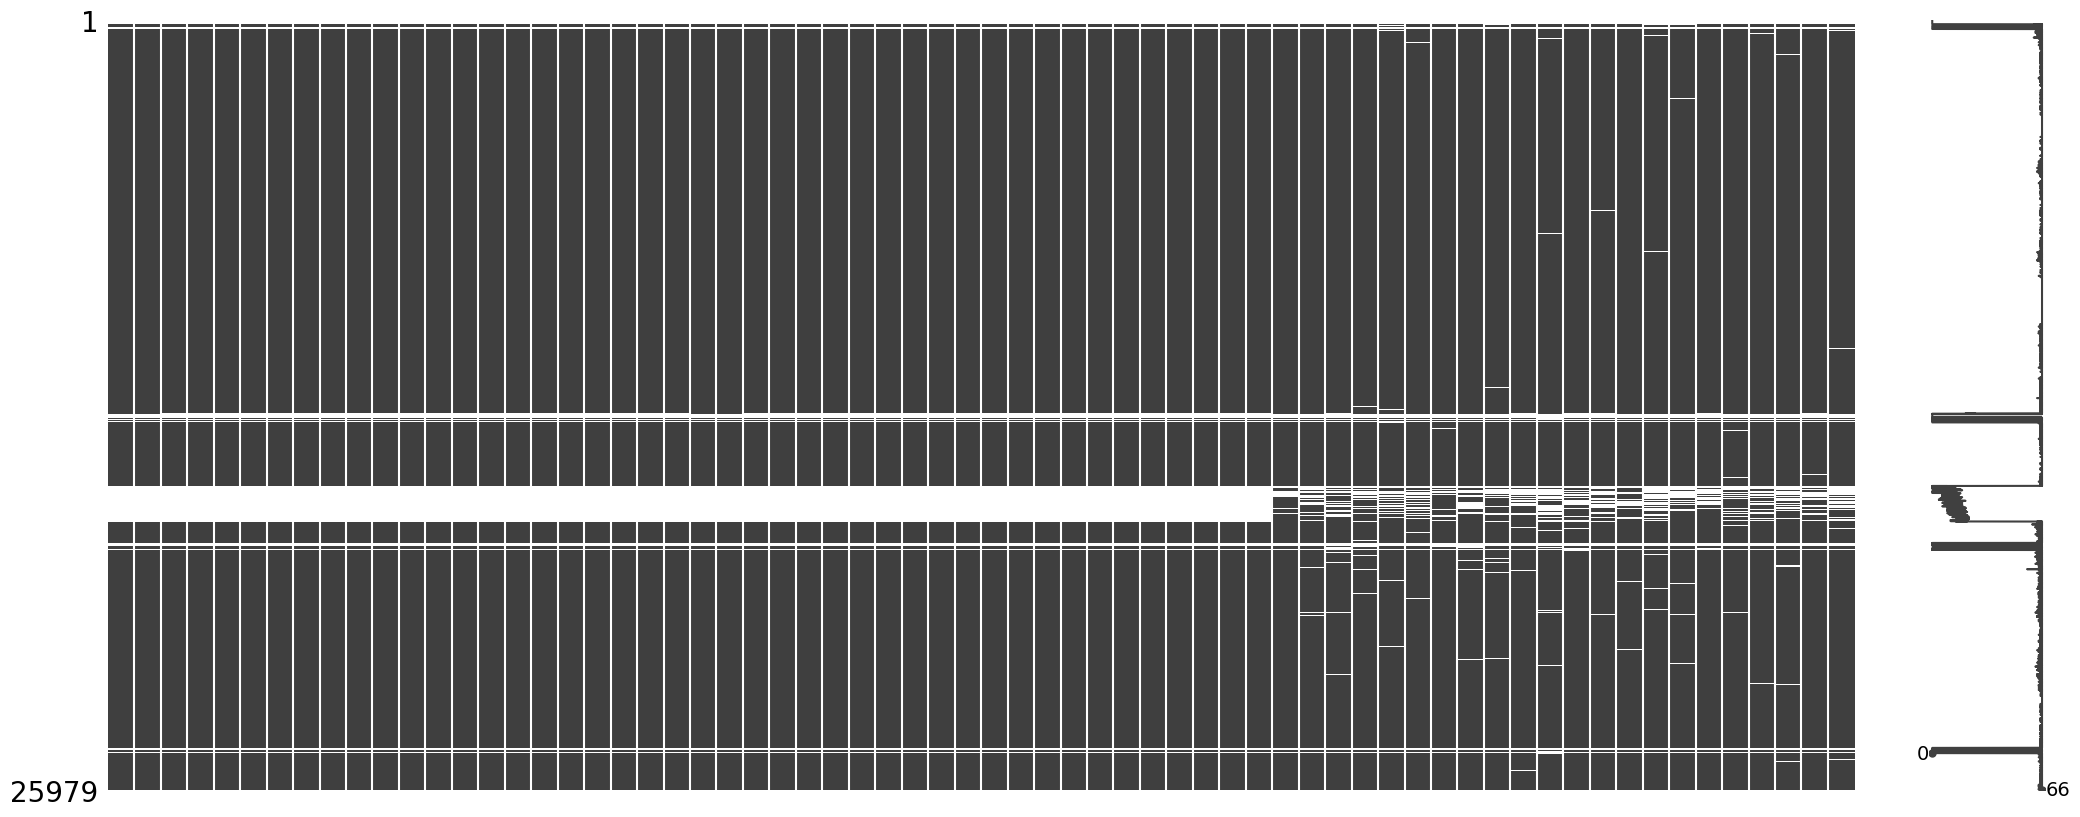

In [66]:
msno.matrix(df_match[player_col])

### 1.3.5. Betting information

In [69]:
df_match[betting_col]

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Before the last letter means betting site.
- Last letter "H": Home win odds
- Last letter "D": Draw odds
- Last letter "A": Away win odds

- Too many similar information.
- Let's just use the summary statistics: 
    - Last word "H": min, max, mean, median, stadard deviation.
    - Last word "D": min, max, mean, median, stadard deviation.
    - Last word "A": min, max, mean, median, stadard deviation.

<AxesSubplot:>

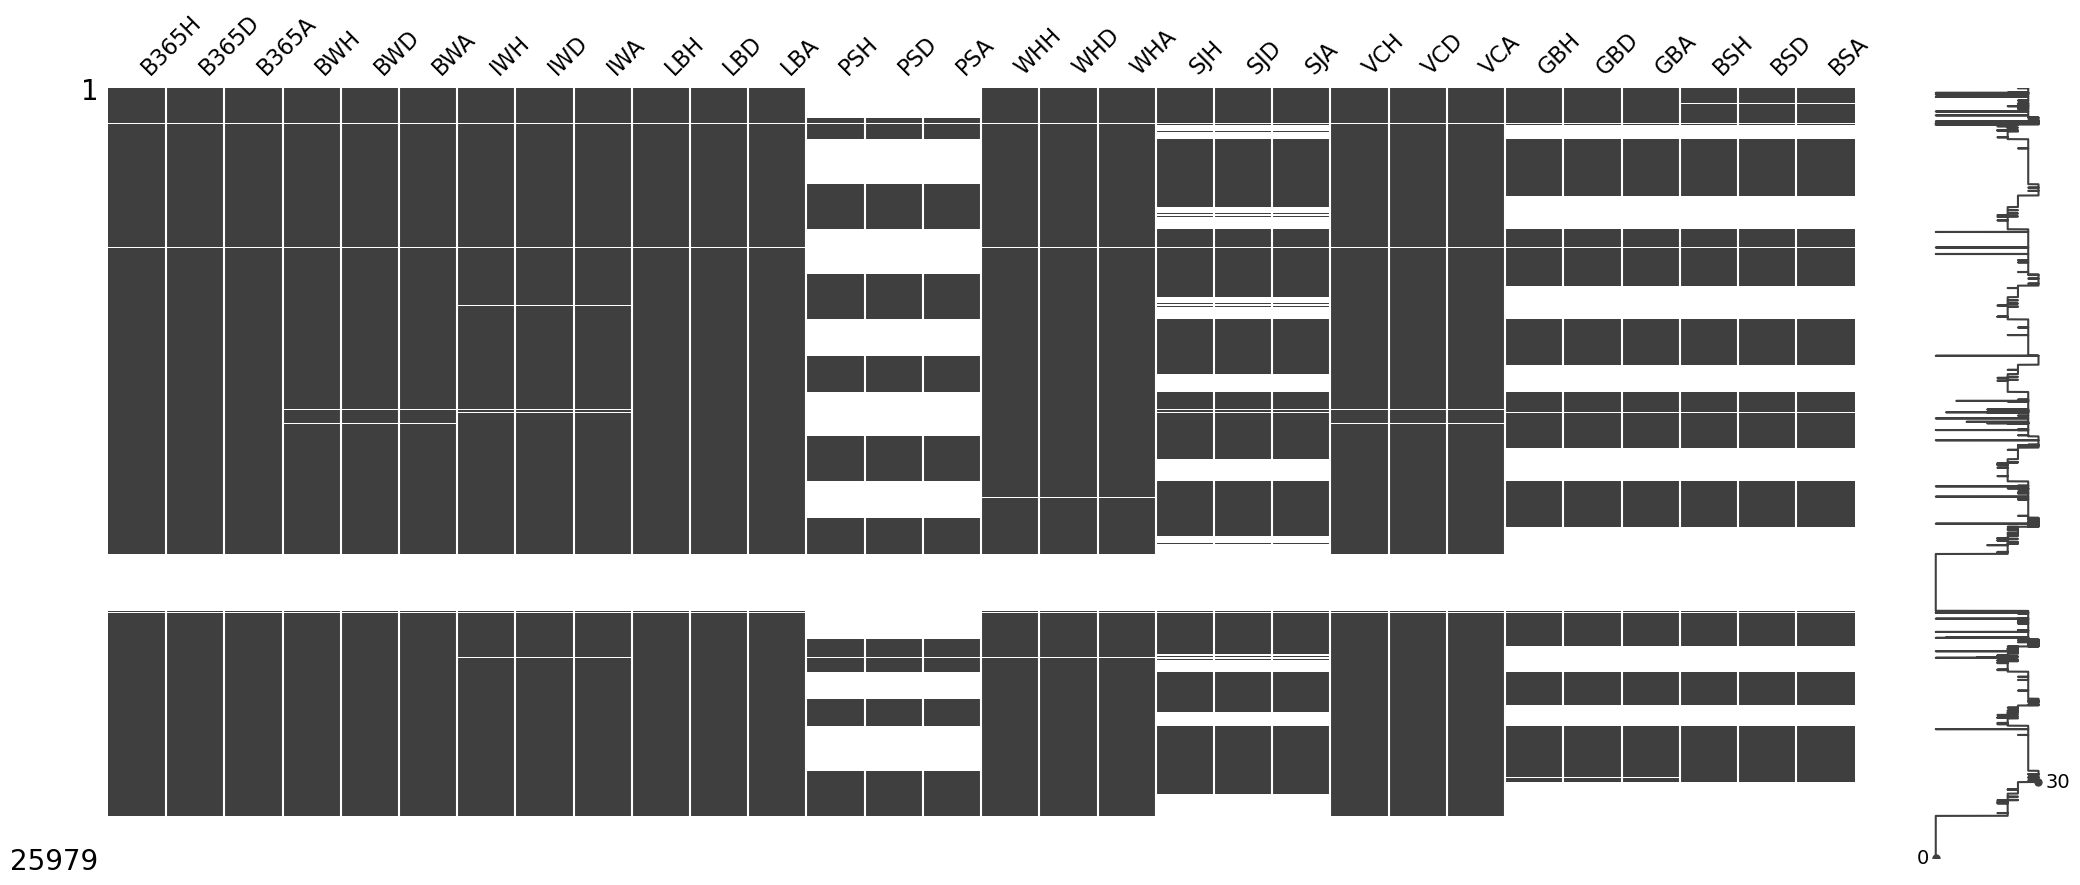

In [71]:
msno.matrix(df_match[betting_col])

In [75]:
np.sum(df_match[betting_col].isna().sum(axis = 1) == 30)

3382

- There are 3,382 matches where all betting information are mssing.
- In these matches, we can 
    - First check the same match.
    - Second check each team's past betting information.

# 2. EDA.

## 2.1. Player related data: Player, Player_Attributes table

- Let's combine the player related tables.

In [422]:
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


- Since player_api_id and player_fifa_api_id have same information, we just use player_api_id to identify the players.

In [508]:
df_player_all = df_player_attr.merge(df_player.drop(["id", "player_fifa_api_id"], axis = 1), how = "left", on = "player_api_id")

In [509]:
df_player_all = df_player_all.drop(["id", "player_fifa_api_id"], axis = 1)

In [510]:
df_player_all.columns

Index(['player_api_id', 'date', 'overall_rating', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
       'player_name', 'birthday', 'height', 'weight'],
      dtype='object')

In [511]:
# just change the columns order

df_player_all = df_player_all[["player_api_id", "player_name", 'birthday', 'height', 'weight', 
                               "date", 'overall_rating', 'potential',
                                'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
                                'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
                                'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
                                'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
                                'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
                                'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
                                'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
                                'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]
df_player_all.head()

,player_api_id,player_name,birthday,height,weight,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


### 2.1.1. birthday

In [512]:
df_player_all.birthday

0         1992-02-29 00:00:00
1         1992-02-29 00:00:00
2         1992-02-29 00:00:00
3         1992-02-29 00:00:00
4         1992-02-29 00:00:00
                 ...         
183973    1982-06-05 00:00:00
183974    1982-06-05 00:00:00
183975    1982-06-05 00:00:00
183976    1982-06-05 00:00:00
183977    1982-06-05 00:00:00
Name: birthday, Length: 183978, dtype: object

- birthday column is complicated format. 
- Let's calculate the age based on the date the player's attributes were measured. That is, age = measured year - birth year

In [513]:
df_player_all["age"] = pd.to_datetime(df_player_all.date).dt.strftime('%Y').astype("int") - pd.to_datetime(df_player_all.birthday).dt.strftime('%Y').astype("int")

In [514]:
df_player_all = df_player_all.drop("birthday", axis = 1)

### 2.1.2. preferred_foot

In [515]:
df_player_all.preferred_foot.unique()

array(['right', 'left', None], dtype=object)

- There are three types for preferred foot.
- There is no both type in prefereed foot.

In [516]:
np.sum(df_player_all[["player_api_id", "preferred_foot"]].drop_duplicates().dropna().groupby("player_api_id").count() == 2)

preferred_foot    1121
dtype: int64

- 1,121 players have both right and left prefereed foot. 
- Let's change these players' prefereed foot as both.

In [517]:
target_boolean = (df_player_all[["player_api_id", "preferred_foot"]].drop_duplicates().groupby("player_api_id").count() == 2)
target_id = target_boolean[target_boolean.preferred_foot].index

In [518]:
df_player_all.loc[df_player_all.player_api_id.isin(target_id), "preferred_foot"] = "both"

- Let's check the missing values in the prefereed foot column.

In [519]:
df_player_all.preferred_foot.isna().sum()

723

- Also, there are 723 missing values in the preferred foot. 
- If the same player, then they will have the same preferred foot. So let's just impute the preferred foot values from same player.

In [520]:
df_player_all["preferred_foot"] = df_player_all.groupby("player_api_id")["preferred_foot"].transform(lambda v: v.ffill())
df_player_all["preferred_foot"] = df_player_all.groupby("player_api_id")["preferred_foot"].transform(lambda v: v.bfill())


In [521]:
df_player_all.preferred_foot.isna().sum()

0

- Now, there is no missing value in the prefereed foot.

<AxesSubplot:xlabel='preferred_foot', ylabel='count'>

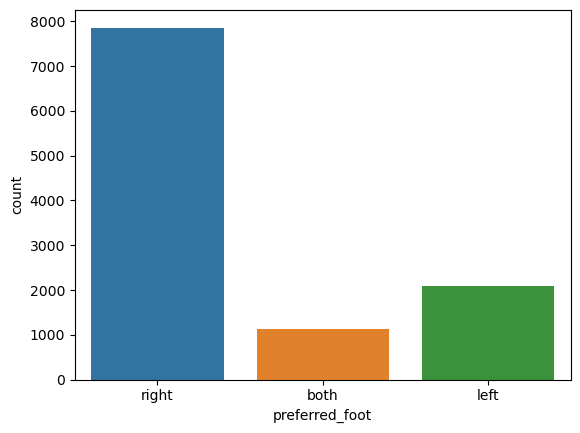

In [522]:
sns.countplot(x = df_player_all[["player_api_id", "preferred_foot"]].drop_duplicates().preferred_foot)

- The majority of players have right preferred footed and the fewest have the both prefereed footed.

### 2.1.3. work_rate: attacking_work_rate, defensive_work_rate

- Player Work Rates affect where players position themselves on the pitch, in the context of their original starting point. They are rated between low, medium, and high, which defines how a player puts effort into participates in attacks and defenses even when they are out of position. They don’t dictate how ‘hard’ a player will perform in attack or defense but rather what types of space they will occupy.

- A high attacking work rate implies that the player will be in all your attack moves. With medium, he will select the attack actions he will join. A player with a low attacking work rate will remain in his position while the team attacks. With the defense, it is the same but in the opposite direction.

- The best way to understand how work rates work is by looking at the post-game heat map for each player on your team. They clearly show where your players were for the majority of the game.


(https://fifauteam.com/fifa-23-work-rates/#:~:text=A%20high%20attacking%20work%20rate,position%20while%20the%20team%20attacks.)

### attacking_work_rate

- Attacking Work Rate (AWR)
    - High: Players will push deep into the attacking third, into the box, into the corners of the wings, etc…
    - Medium: Players will play from the midfield to outside the penalty area.
    - Low: Players will not play much further than from outside the defensive penalty area up to the defensive midfield.

<AxesSubplot:xlabel='attacking_work_rate', ylabel='count'>

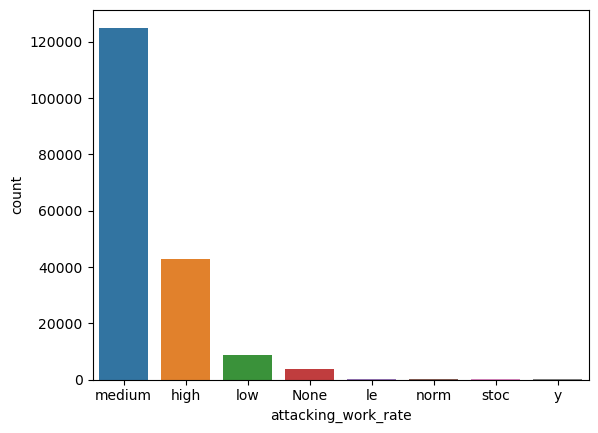

In [523]:
sns.countplot(x = df_player_all.attacking_work_rate)

- Except for high, medium, and low, other categories exist.
- Let's treat them as a missing value

In [524]:
df_player_all.loc[~df_player_all.attacking_work_rate.isin(["medium", "high", "low"]), "attacking_work_rate"] = np.nan 

In [525]:
df_player_all.attacking_work_rate.isna().sum()

7516

- There are 7,516 missing values in the attacking_work_rate column.

In [526]:
df_player_all.groupby(["player_api_id"]).nunique().attacking_work_rate.value_counts()

1    7123
2    2754
0    1109
3      74
Name: attacking_work_rate, dtype: int64

<AxesSubplot:xlabel='attacking_work_rate', ylabel='count'>

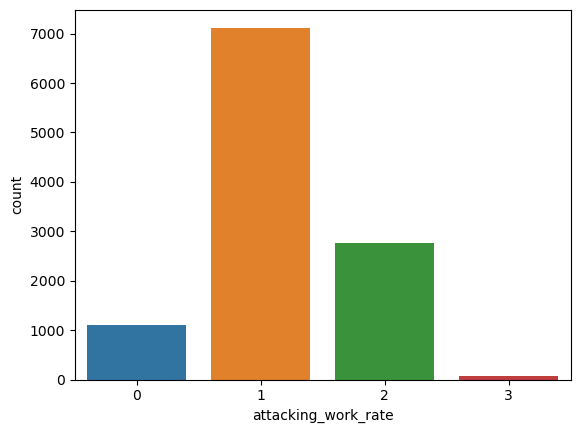

In [527]:
sns.countplot(x = df_player_all.groupby(["player_api_id"]).nunique().attacking_work_rate)

- 65% (7123 / 11060) players have only one attacking_work_rate value for multiple measurements of attacking_work_rate.
- So let's just impute the missing values with the immediately preceding measurement or the immediately following measurement from each player.

In [528]:
df_player_all["attacking_work_rate"] = df_player_all.groupby("player_api_id")["attacking_work_rate"].transform(lambda v: v.ffill())
df_player_all["attacking_work_rate"] = df_player_all.groupby("player_api_id")["attacking_work_rate"].transform(lambda v: v.bfill())

In [529]:
len(df_player_all[df_player_all.attacking_work_rate.isna()].player_api_id.unique())

1109

- There are still 1109 players who have the missing values in the attacking_work_rate.

<AxesSubplot:xlabel='attacking_work_rate', ylabel='count'>

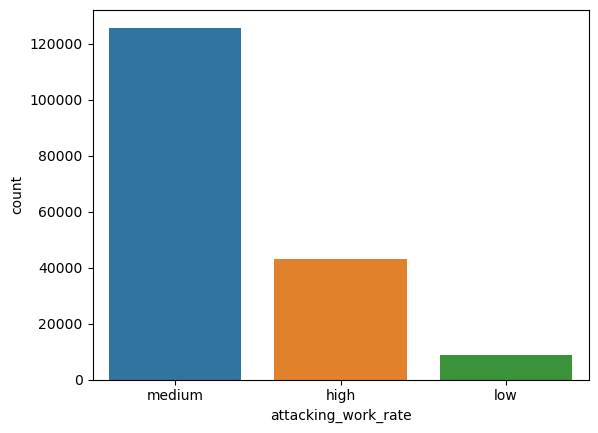

In [530]:
sns.countplot(x = df_player_all.attacking_work_rate)

- Since "medium" attacking_work_rate is the most case, let's just impute the "medium" to the missing values in the attacking_work_rate column. 

In [531]:
df_player_all.loc[df_player_all.attacking_work_rate.isna(), "attacking_work_rate"] = "medium"

In [532]:
df_player_all.attacking_work_rate.isna().sum()

0

### defensive_work_rate

- Defensive Work Rate (DWR)
    - High: Players will drop deep into the defensive third, into the box, into the corners of the wings, etc…
    - Medium: Players will play from the midfield to outside the defensive penalty area.
    - Low: Players will not drop much further than outside the attacking penalty area up to the attacking midfield.

<AxesSubplot:xlabel='defensive_work_rate', ylabel='count'>

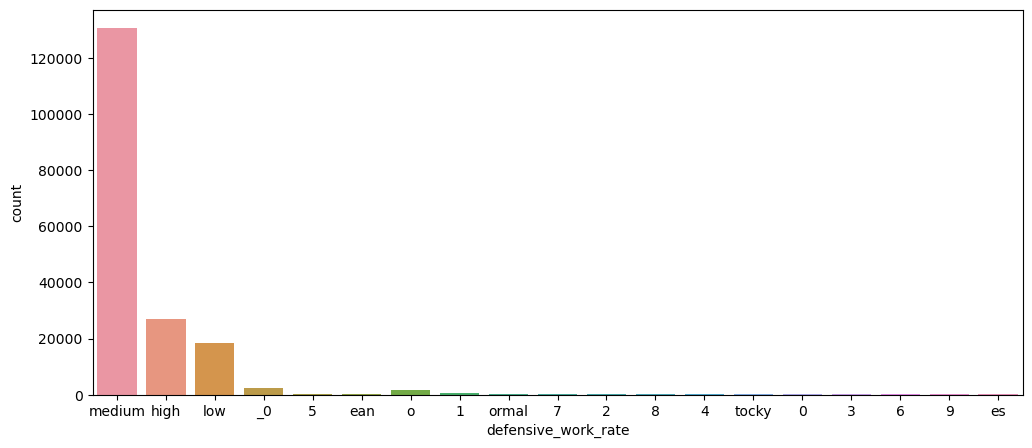

In [533]:
plt.figure(figsize = (12, 5))
sns.countplot(x = df_player_all.defensive_work_rate)

- Except for high, medium, and low, other categories exist.
- Let's treat them as a missing value

In [534]:
df_player_all.loc[~df_player_all.defensive_work_rate.isin(["medium", "high", "low"]), "defensive_work_rate"] = np.nan 

In [535]:
df_player_all.defensive_work_rate.isna().sum()

7659

- There are 7,516 missing values in the defensive_work_rate column.

In [536]:
df_player_all.groupby(["player_api_id"]).nunique().defensive_work_rate.value_counts()

1    7441
2    2369
0    1122
3     128
Name: defensive_work_rate, dtype: int64

<AxesSubplot:xlabel='defensive_work_rate', ylabel='count'>

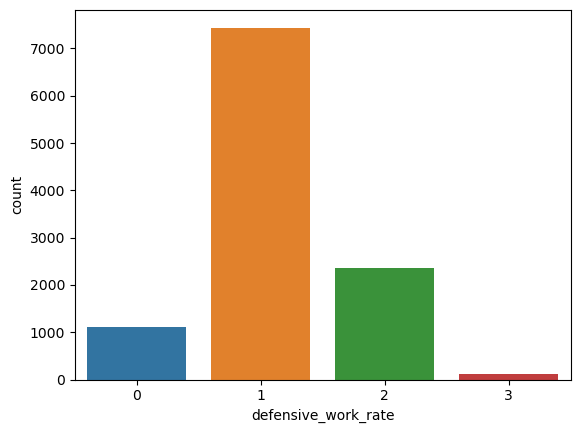

In [537]:
sns.countplot(x = df_player_all.groupby(["player_api_id"]).nunique().defensive_work_rate)

- 67% (7441 / 11060) players have only one defensive_work_rate value for multiple measurements of defensive_work_rate.
- So let's just impute the missing values with the immediately preceding measurement or the immediately following measurement from each player.

In [538]:
df_player_all["defensive_work_rate"] = df_player_all.groupby("player_api_id")["defensive_work_rate"].transform(lambda v: v.ffill())
df_player_all["defensive_work_rate"] = df_player_all.groupby("player_api_id")["defensive_work_rate"].transform(lambda v: v.bfill())

In [539]:
len(df_player_all[df_player_all.defensive_work_rate.isna()].player_api_id.unique())

1122

- There are still 1122 players who have the missing values in the defensive_work_rate.

<AxesSubplot:xlabel='defensive_work_rate', ylabel='count'>

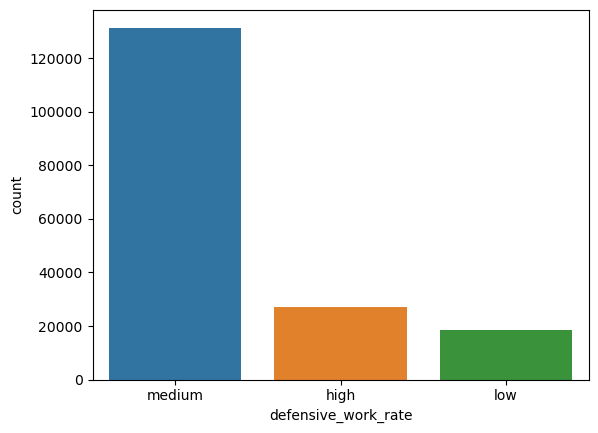

In [540]:
sns.countplot(x = df_player_all.defensive_work_rate)

- Since "medium" defensive_work_rate is the most case, let's just impute the "medium" to the missing values in the defensive_work_rate column. 

In [541]:
df_player_all.loc[df_player_all.defensive_work_rate.isna(), "defensive_work_rate"] = "medium"

In [542]:
df_player_all.defensive_work_rate.isna().sum()

0

### 2.1.4. Other numerical player attributes

In [555]:
player_num_attr = ["player_api_id", "date", "height", "weight", "age",
                   'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
                   'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
                   'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 
                   'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
                   'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
                   'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
                   'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning','gk_reflexes']

<AxesSubplot:>

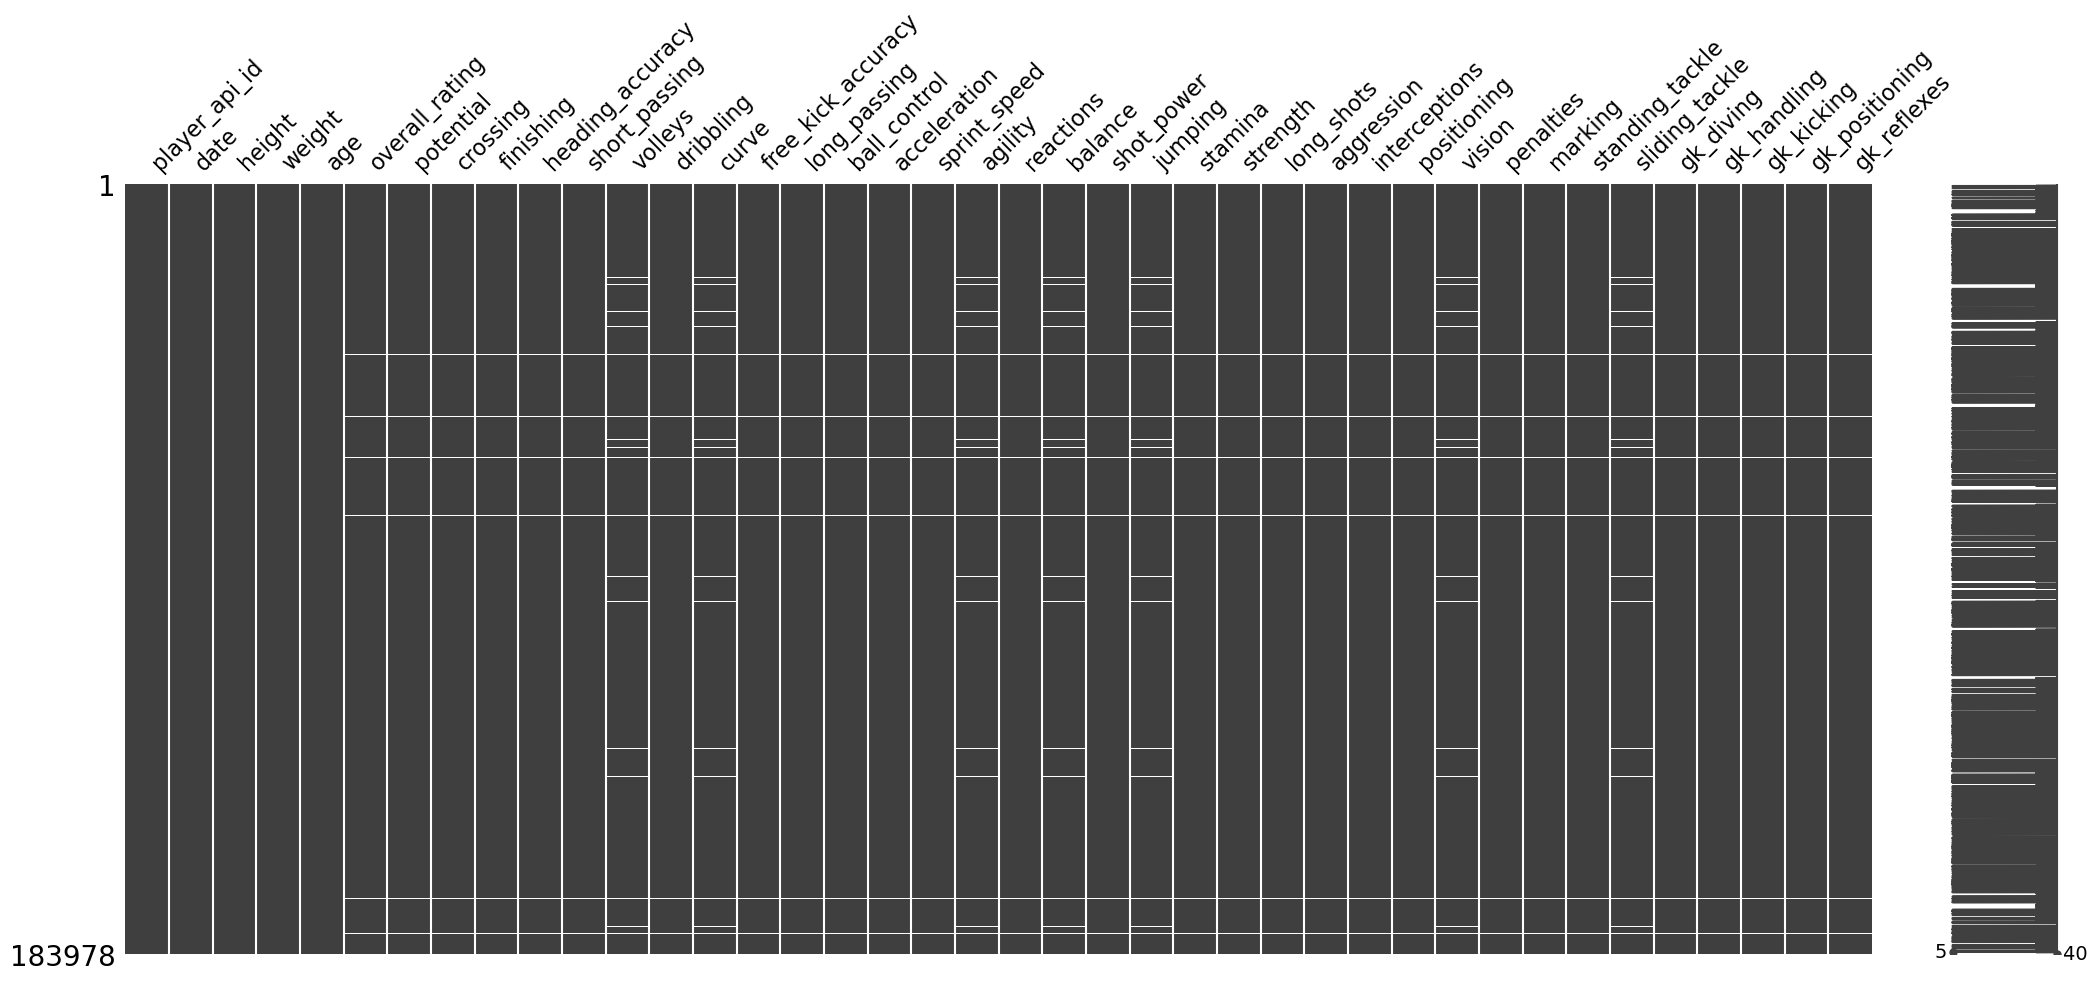

In [544]:
msno.matrix(df_player_all[player_num_attr])

- If overall_rating is missing, all other attributes are also msissing.

In [545]:
df_player_all.overall_rating.isna().sum()

836

- There are only 836 cases that overall_rating and all other attributes are missing.

In [546]:
len(df_player_all[~df_player_all.overall_rating.isna()].player_api_id.unique())

11060

- Also, even if we drop the cases that overall_rating is missing, we can check that each player's attributes have been measured at least once.
- So let's just drop the cases that overall_rating is missing.

In [547]:
df_player_all = df_player_all[~df_player_all.overall_rating.isna()]

<AxesSubplot:>

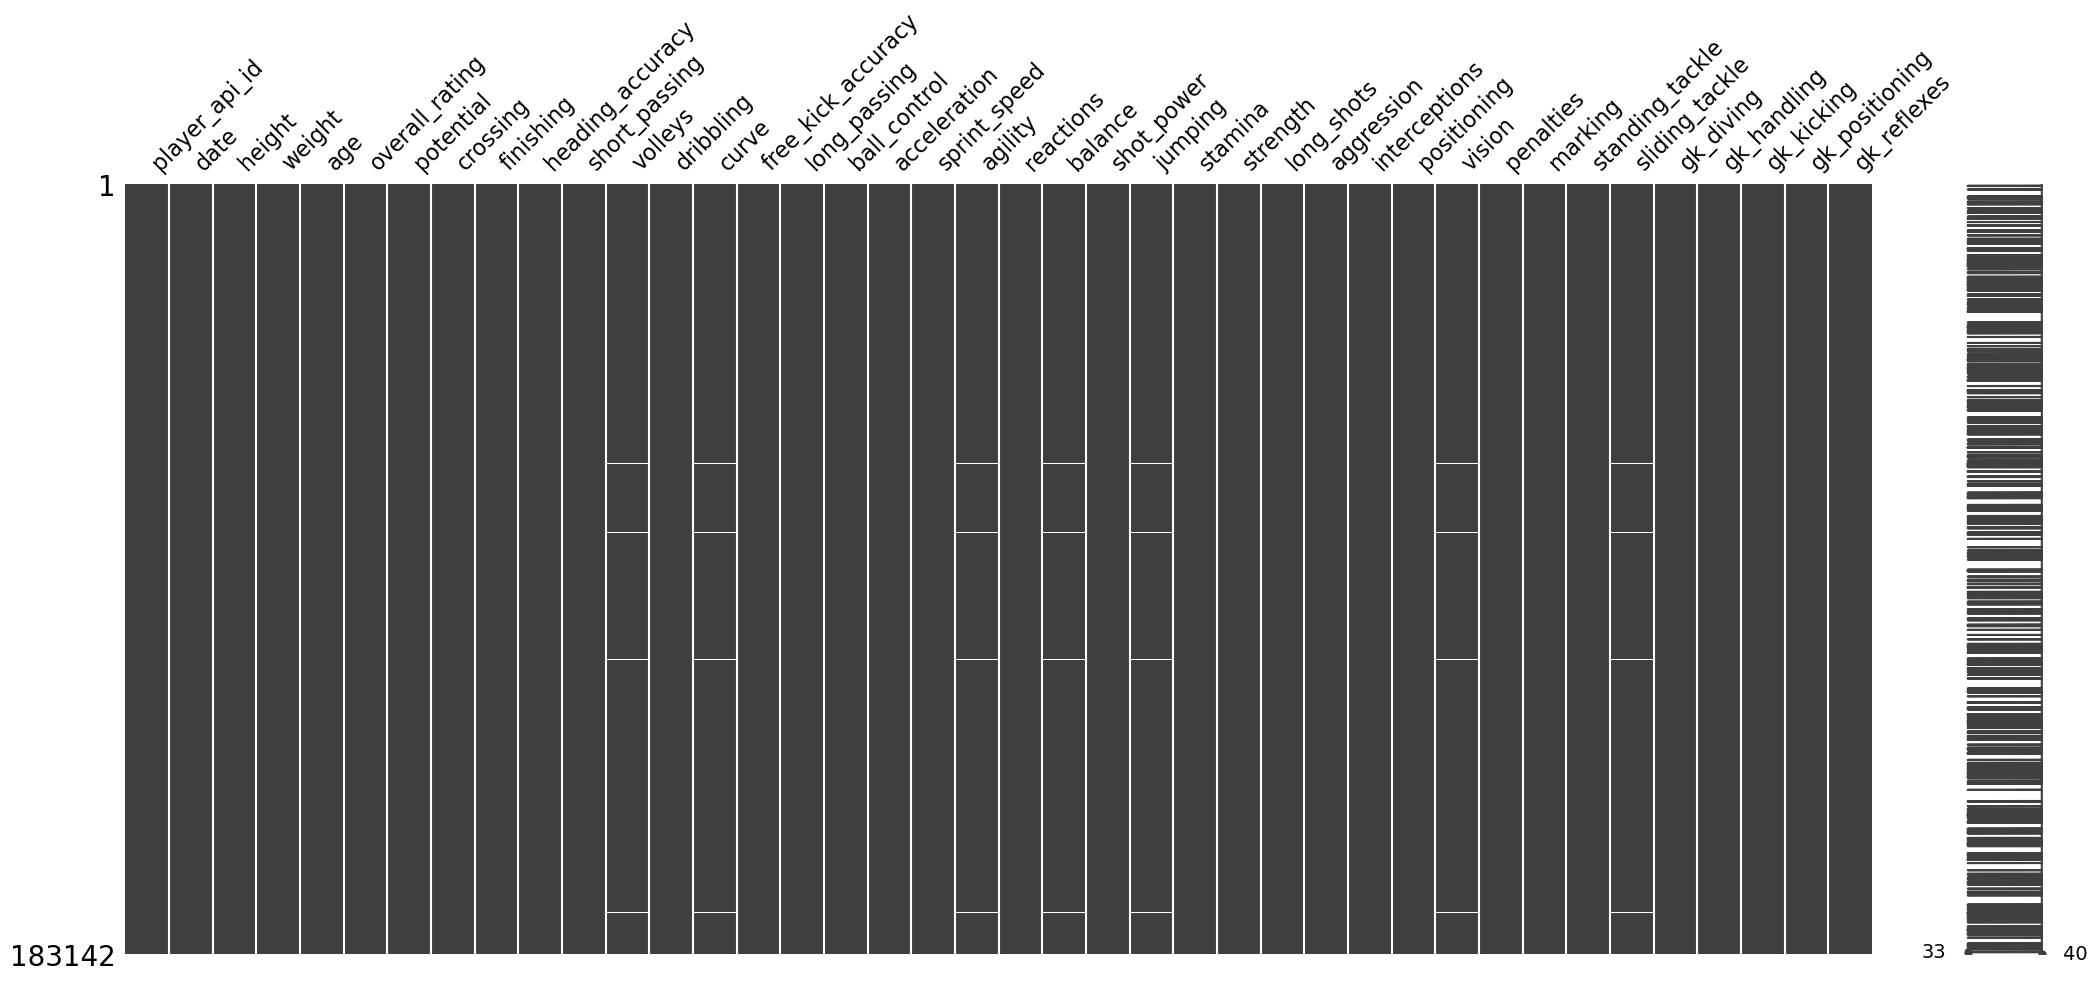

In [548]:
msno.matrix(df_player_all[player_num_attr])

In [549]:
df_player_all[player_num_attr].isna().sum()[df_player_all[player_num_attr].isna().sum() > 0]

volleys           1877
curve             1877
agility           1877
balance           1877
jumping           1877
vision            1877
sliding_tackle    1877
dtype: int64

- There are some missing values in voleys, curve, agility, balance, jumping, vision, sliding_tackle variables.
- Let's check the correlation between attributes to check whether missing values ​​can be imputed by other variables.

/var/folders/kb/9bgdwxjn0b751yc9w59v1ll00000gn/T/ipykernel_76974/3977754592.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(df_player_all[player_num_attr].corr(), 1)


<AxesSubplot:>

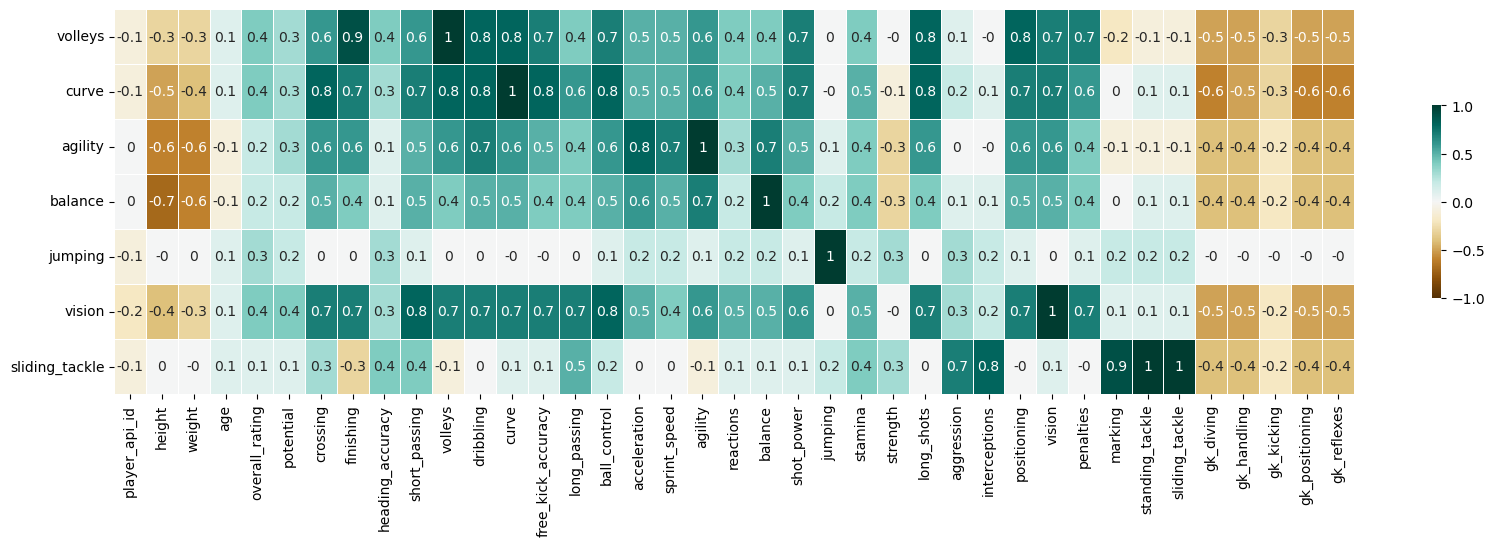

In [550]:
plt.figure(figsize = (20, 5))

corr = round(df_player_all[player_num_attr].corr(), 1)
corr = corr.loc[["volleys", "curve", "agility", "balance", "jumping", "vision", "sliding_tackle"], :]

sns.heatmap(corr, annot = True, cmap = "BrBG", vmin = -1, vmax = 1, 
            linewidths = 0.5, cbar_kws = {"shrink" : 0.5})


- We can see that there are absolute correlations over 0.7 between:
    - volleys: finishing, dribbling, curve, positioning, long_shots, dribbling, positioning, curve, ball_control, shot_power,
                                         penalties
    - curve: dribbling, long_shots, crossing, ball_control, free_kick_accuracy, volleys, short_passing, vision, positioning
    - agility: acceleration, sprint_speed, dribbling
    - balance: agility, height
    - jumping: none
    - vision: ball_control, short_passing, positioning, dribbling, long_shots, curve, free_kick_accuracy, crossing, 
              volleys, long_passing, penalties, finishing
    - sliding_tackle: standing_tackle, marking, interceptions, aggression

- There are plenty of other variables that have high correlation with the variables that have the missing values, except for the balance and jumping.
- So, it seems to be possible to use the iterative imputation for the missing values from the player attributes, except for the balance and jumping.

- However, since only 1%(1877 / 183142) of the data have missing values in banace and jumping columns, let's also use the iterative imputation even for the balance and jumping.

In [559]:
target = df_player_all[player_num_attr].set_index(["player_api_id", "date"])

index = target.index
col_names = target.columns

imp_player_attr = IterativeImputer(max_iter = 10, random_state = 42)
imp_player_attr.fit(target)
player_num_attr_imputed = pd.DataFrame(imp_player_attr.transform(target), 
                                       columns = col_names, index = index)


In [561]:
player_num_attr_imputed.head()

height  weight   age  overall_rating  \
player_api_id date                                                        
505942        2016-02-18 00:00:00  182.88   187.0  24.0            67.0   
              2015-11-19 00:00:00  182.88   187.0  23.0            67.0   
              2015-09-21 00:00:00  182.88   187.0  23.0            62.0   
              2015-03-20 00:00:00  182.88   187.0  23.0            61.0   
              2007-02-22 00:00:00  182.88   187.0  15.0            61.0   

                                   potential  crossing  finishing  \
player_api_id date                                                  
505942        2016-02-18 00:00:00       71.0      49.0       44.0   
              2015-11-19 00:00:00       71.0      49.0       44.0   
              2015-09-21 00:00:00       66.0      49.0       44.0   
              2015-03-20 00:00:00       65.0      48.0       43.0   
              2007-02-22 00:00:00       65.0      48.0       43.0   

                                   heading_accuracy  short_passing  volleys  \
player_api_id date                                                            
505942        2016-02-18 00:00:00              71.0           61.0     44.0   
              2015-11-19 00:00:00              71.0           61.0     44.0   
              2015-09-21 00:00:00              71.0           61.0     44.0   
              2015-03-20 00:00:00              70.0           60.0     43.0   
              2007-02-22 00:00:00              70.0           60.0     43.0   

                                   dribbling  curve  free_kick_accuracy  \
player_api_id date                                                        
505942        2016-02-18 00:00:00       51.0   45.0                39.0   
              2015-11-19 00:00:00       51.0   45.0                39.0   
              2015-09-21 00:00:00       51.0   45.0                39.0   
              2015-03-20 00:00:00       50.0   44.0                38.0   
              2007-02-22 00:00:00       50.0   44.0                38.0   

                                   long_passing  ball_control  acceleration  \
player_api_id date                                                            
505942        2016-02-18 00:00:00          64.0          49.0          60.0   
              2015-11-19 00:00:00          64.0          49.0          60.0   
              2015-09-21 00:00:00          64.0          49.0          60.0   
              2015-03-20 00:00:00          63.0          48.0          60.0   
              2007-02-22 00:00:00          63.0          48.0          60.0   

                                   sprint_speed  agility  reactions  balance  \
player_api_id date                                                             
505942        2016-02-18 00:00:00          64.0     59.0       47.0     65.0   
              2015-11-19 00:00:00          64.0     59.0       47.0     65.0   
              2015-09-21 00:00:00          64.0     59.0       47.0     65.0   
              2015-03-20 00:00:00          64.0     59.0       46.0     65.0   
              2007-02-22 00:00:00          64.0     59.0       46.0     65.0   

                                   shot_power  jumping  stamina  strength  \
player_api_id date                                                          
505942        2016-02-18 00:00:00        55.0     58.0     54.0      76.0   
              2015-11-19 00:00:00        55.0     58.0     54.0      76.0   
              2015-09-21 00:00:00        55.0     58.0     54.0      76.0   
              2015-03-20 00:00:00        54.0     58.0     54.0      76.0   
              2007-02-22 00:00:00        54.0     58.0     54.0      76.0   

                                   long_shots  aggression  interceptions  \
player_api_id date                                                         
505942        2016-02-18 00:00:00        35.0        71.0           70.0   
              2015-11-19 00:00:00        35.0        71.0     

<AxesSubplot:>

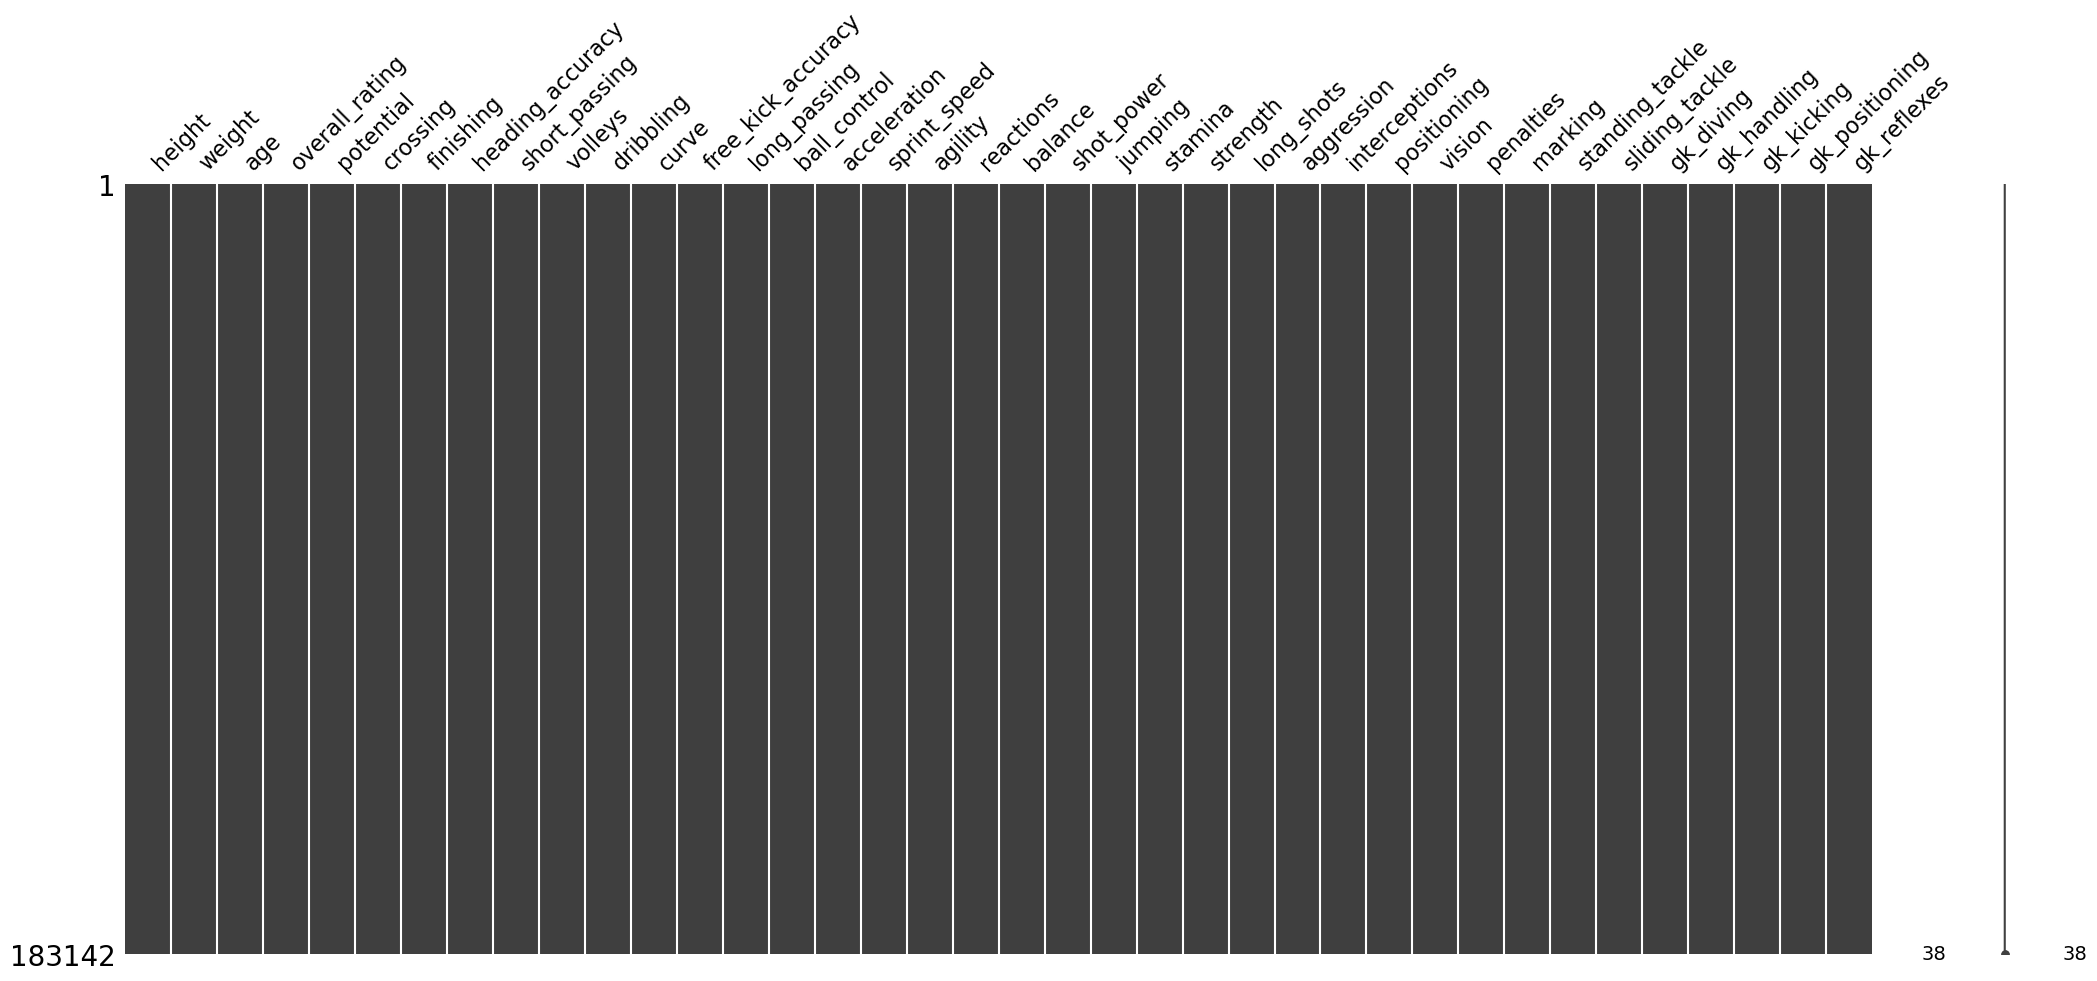

In [560]:
msno.matrix(player_num_attr_imputed)

- Merge the imputed data.

In [563]:
df_player_all_imputed = df_player_all[["player_api_id", "player_name", "height", "weight", "age", "date", 
                                       "preferred_foot", "attacking_work_rate", "defensive_work_rate"]].merge(
    player_num_attr_imputed.drop(["height", "weight", "age"], axis = 1).reset_index(),
    how = "left", on = ["player_api_id", "date"]
)

In [564]:
df_player_all_imputed.head()

,player_api_id,player_name,height,weight,age,date,preferred_foot,attacking_work_rate,defensive_work_rate,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,182.88,187,24,2016-02-18 00:00:00,right,medium,medium,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,182.88,187,23,2015-11-19 00:00:00,right,medium,medium,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,182.88,187,23,2015-09-21 00:00:00,right,medium,medium,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,182.88,187,23,2015-03-20 00:00:00,right,medium,medium,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,182.88,187,15,2007-02-22 00:00:00,right,medium,medium,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [565]:
df_player_all_imputed.shape

(183142, 44)

## 2.2. Match related data: Match table 

In [815]:
basic_match_information_col = ["country_id", "league_id", "home_team_api_id", "away_team_api_id", "season", "stage", "date"]
in_game_col = ['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']
match_result_col = ["home_team_goal", "away_team_goal"]
player_col = ['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
              'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 
              'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
              'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
              'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
              'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
              'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
              'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
              'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 
              'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 
              'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 
              'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 
              'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']
betting_col = ["match_api_id", 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 
               'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 
               'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

### 2.2.1. Basic match information

In [597]:
df_league.rename(columns = {"name": "League"}).merge(
    df_country.rename(columns = {"id" : "country_id", "name" : "Country"}),
    how = "left",
    on = "country_id"
)[["Country", "League"]]

,Country,League
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


- There is only one league from each country and league name also contain the country information.
- So, let's just use the league instead of the country.
- There are total 11 leagues.

In [607]:
df_match_basic = df_match[basic_match_information_col].merge(
    df_league.rename({"name" : "league"}, axis = 1), how = "left", on = "country_id").drop("id", axis = 1)

# just reorder the columns
df_match_basic = df_match_basic[["league", "season", "stage", "date", "home_team_api_id", "away_team_api_id"]]
df_match_basic

,league,season,stage,date,home_team_api_id,away_team_api_id
0,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,9987,9993
1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,10000,9994
2,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,9984,8635
3,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,9991,9998
4,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,7947,9985
...,...,...,...,...,...,...
25974,Switzerland Super League,2015/2016,9,2015-09-22 00:00:00,10190,10191
25975,Switzerland Super League,2015/2016,9,2015-09-23 00:00:00,9824,10199
25976,Switzerland Super League,2015/2016,9,2015-09-23 00:00:00,9956,10179
25977,Switzerland Super League,2015/2016,9,2015-09-22 00:00:00,7896,10243


In [609]:
df_match_basic.groupby(["league"]).nunique().season

league
Belgium Jupiler League      8
England Premier League      8
France Ligue 1              8
Germany 1. Bundesliga       8
Italy Serie A               8
Netherlands Eredivisie      8
Poland Ekstraklasa          8
Portugal Liga ZON Sagres    8
Scotland Premier League     8
Spain LIGA BBVA             8
Switzerland Super League    8
Name: season, dtype: int64

In [610]:
df_match_basic.season.unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

- Each league has the match information for 8 years from 2008/2009 to 2015/2016 seasons

Text(0.5, 1.0, '8 Seasons: 2008/2009 ~ 2015/2016')

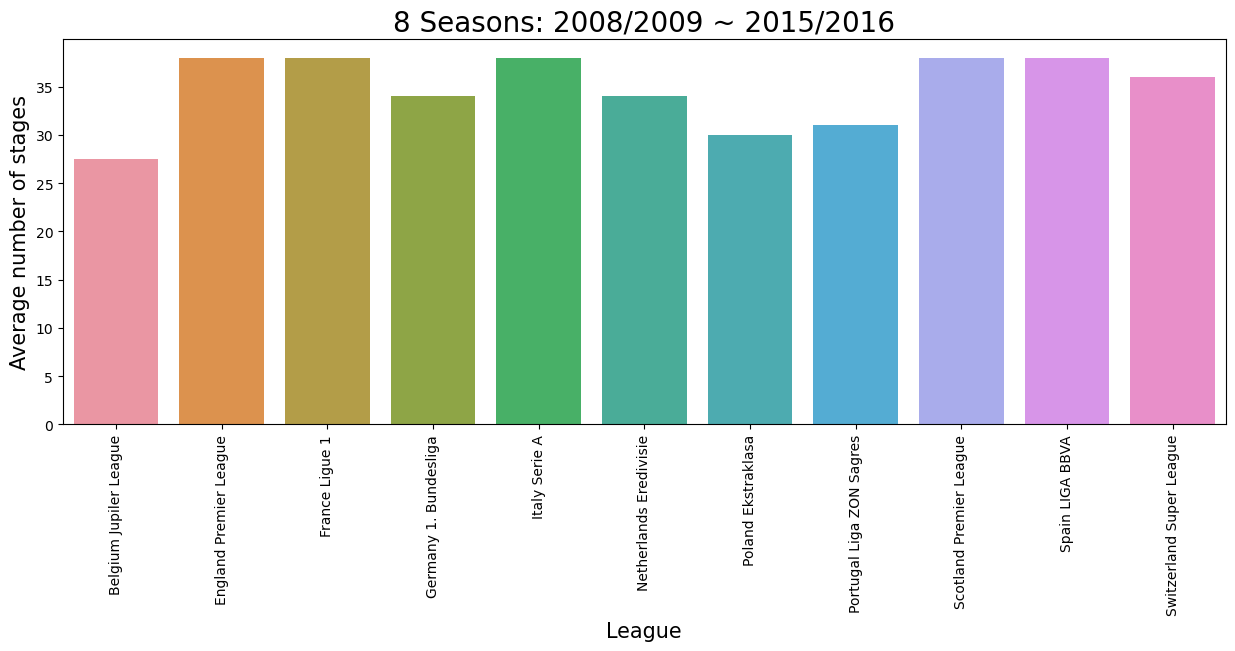

In [631]:
plt.figure(figsize = (15, 5))
sns.barplot(df_match_basic.groupby(["league", "season"]).stage.nunique().reset_index().groupby(["league"]).stage.mean().reset_index(),
            x = "league", y = "stage")
plt.ylabel("Average number of stages", fontsize = 15)
plt.xlabel("League", fontsize = 15)
plt.xticks(rotation=90)
plt.title("8 Seasons: 2008/2009 ~ 2015/2016", fontsize = 20)

- Above bar graph shows the average number of stages for 8 seasons from each league.

### 2.2.2. In-game information

- Will do later

### 2.2.3. Match result information

In [637]:
df_match_result = pd.concat([df_match_basic[["league", "season", "stage", "home_team_api_id", "away_team_api_id"]], df_match[match_result_col]], axis = 1)
df_match_result.head()

,league,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,Belgium Jupiler League,2008/2009,1,9987,9993,1,1
1,Belgium Jupiler League,2008/2009,1,10000,9994,0,0
2,Belgium Jupiler League,2008/2009,1,9984,8635,0,3
3,Belgium Jupiler League,2008/2009,1,9991,9998,5,0
4,Belgium Jupiler League,2008/2009,1,7947,9985,1,3


### Home & away goals trend

- Let's check the home, away goals trend for 8 seasons from each league.

In [651]:
goals_trend = df_match_result.groupby(["league", "season"]).mean()[["home_team_goal", "away_team_goal"]].reset_index()

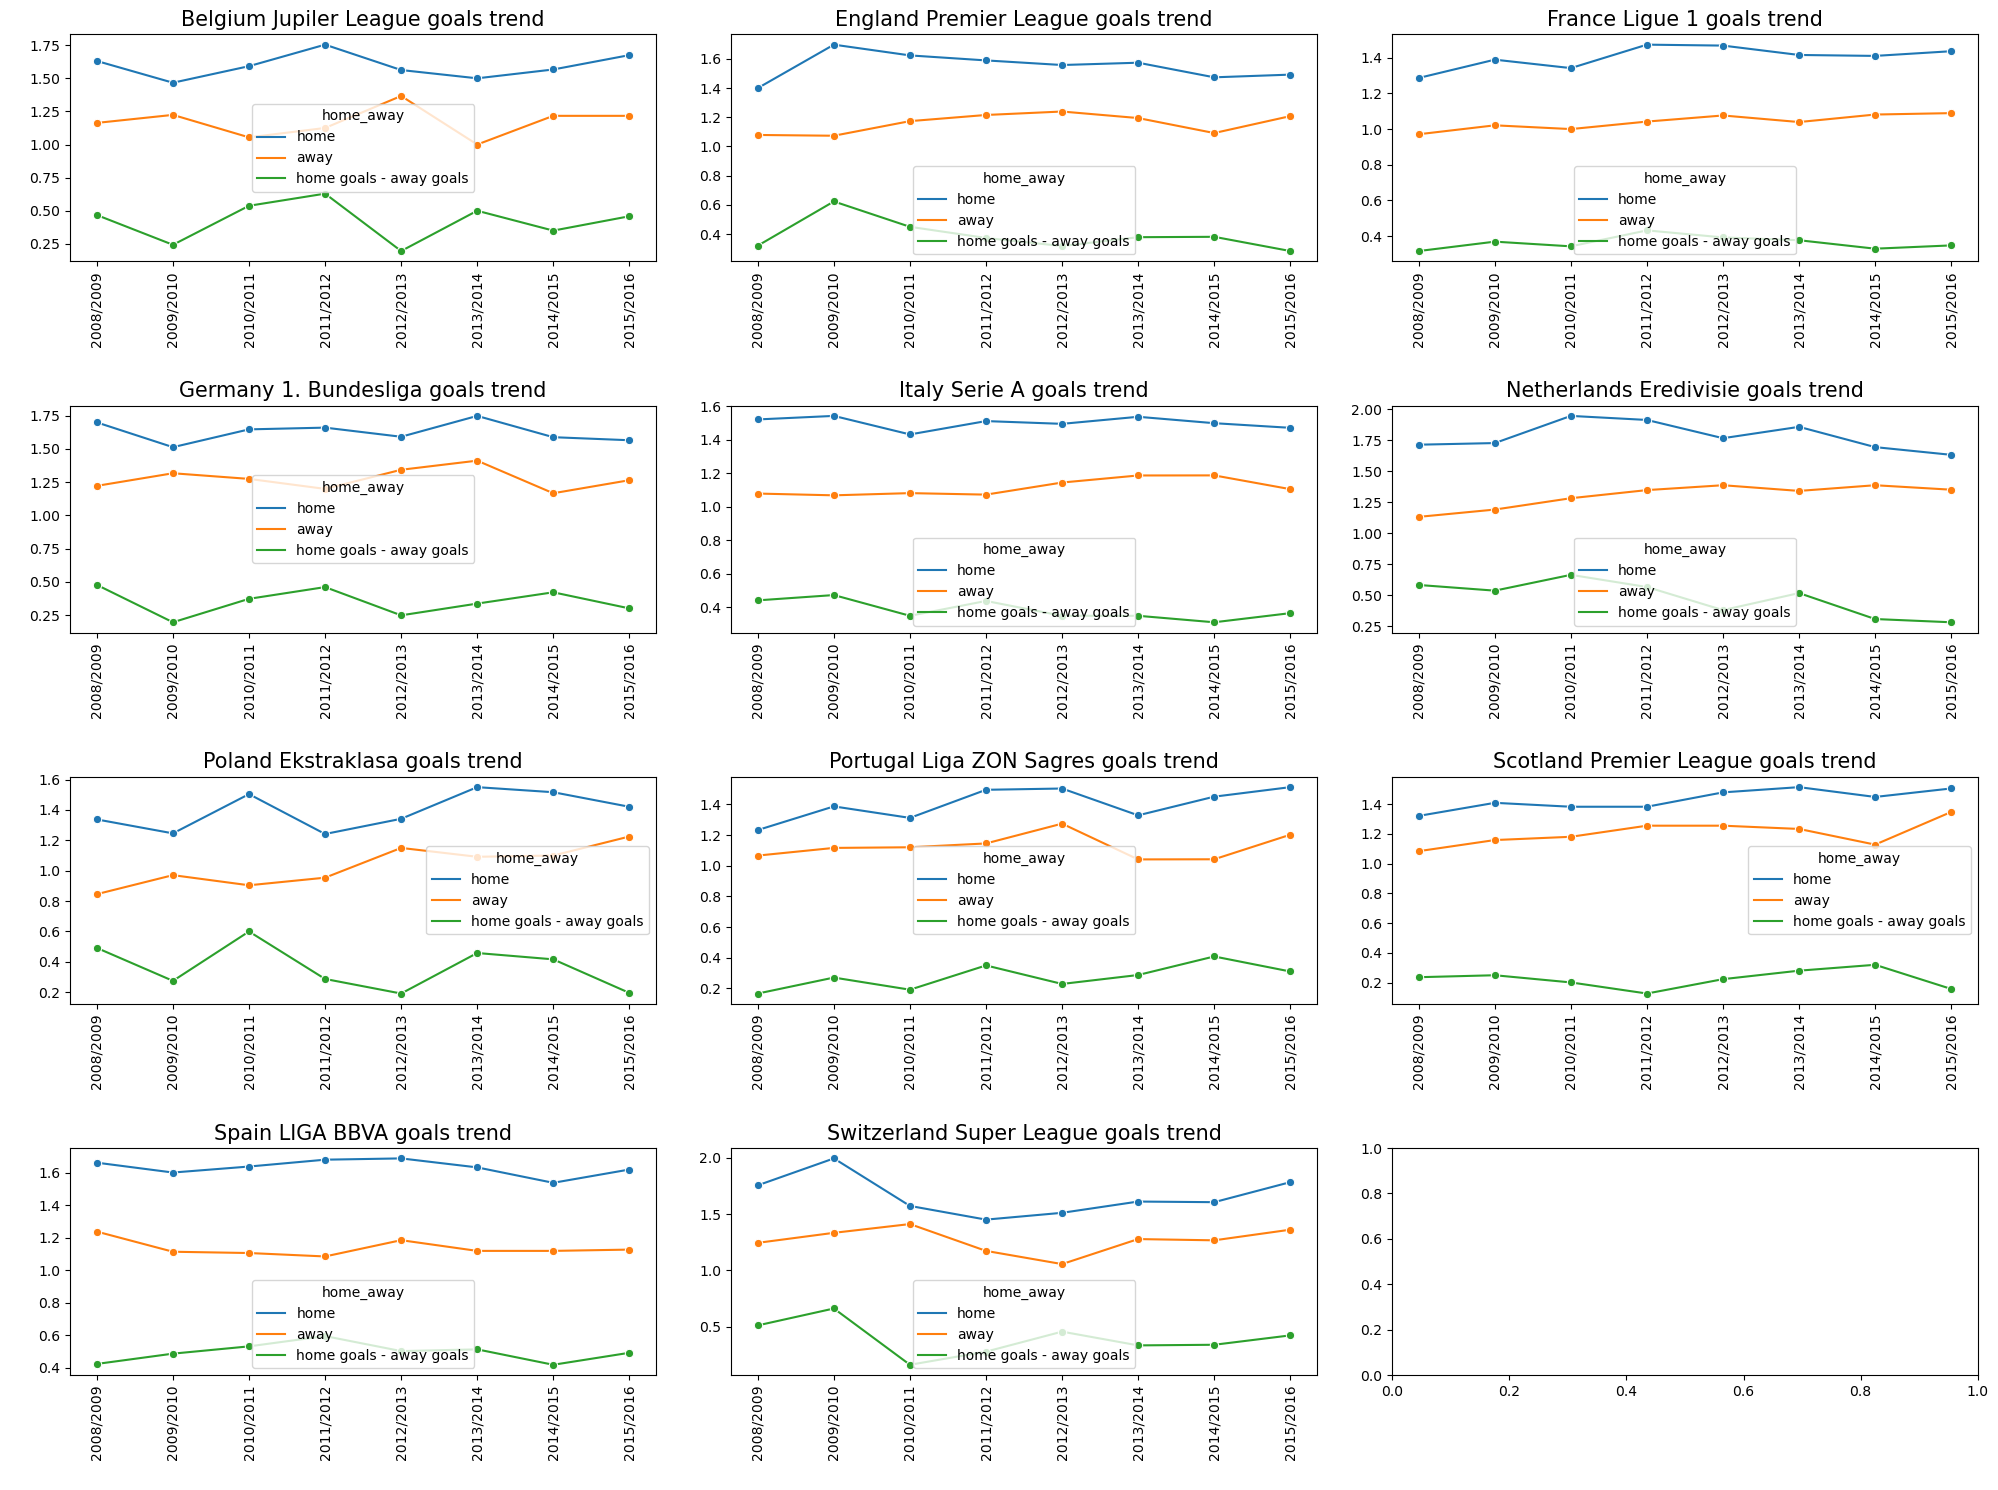

In [709]:
fig, axes = plt.subplots(4, 3, figsize = (20, 15))

for i, league in enumerate(goals_trend.league.unique()):
    home = goals_trend.loc[goals_trend.league == league, ["league", "season", "home_team_goal"]].rename(columns = {"home_team_goal" : "goals"})
    home["home_away"] = "home"

    away = goals_trend.loc[goals_trend.league == league, ["league", "season", "away_team_goal"]].rename(columns = {"away_team_goal" : "goals"})
    away["home_away"] = "away"
    
    home_m_away = home.copy()
    home_m_away["goals"] = home.goals - away.goals 
    home_m_away["home_away"] = "home goals - away goals"

    home_away = pd.concat([home, away, home_m_away], axis = 0)
    
    sns.lineplot(data = home_away, x = "season", y = "goals", hue = "home_away", marker = "o", ax = axes[i // 3, i % 3])

    axes[i // 3, i % 3].set_xlabel(" ", fontsize = 10)
    axes[i // 3, i % 3].set_ylabel(" ", fontsize = 10)
    axes[i // 3, i % 3].set_title(f"{league} goals trend", fontsize = 15)
    axes[i // 3, i % 3].tick_params(axis='x', labelrotation = 90)

plt.tight_layout()
    
    



- Home team scores more goals than away team in all leagues
- The gap between the average number of home goals and the average number of away goals has remained similar across all leagues.
- Since there is not much difference between home team goals and away team goals by season in all leagues, let's check the distribution without considering the season.

### Home & away goals distribution

In [719]:
df_match_result.groupby("league").home_team_goal.describe()

,count,mean,std,min,25%,50%,75%,max
league,,,,,,,,
Belgium Jupiler League,1728.0,1.609375,1.293458,0.0,1.0,1.0,2.0,7.0
England Premier League,3040.0,1.550987,1.311615,0.0,1.0,1.0,2.0,9.0
France Ligue 1,3040.0,1.402961,1.170743,0.0,1.0,1.0,2.0,6.0
Germany 1. Bundesliga,2448.0,1.626634,1.339529,0.0,1.0,1.0,2.0,9.0
Italy Serie A,3017.0,1.500829,1.221797,0.0,1.0,1.0,2.0,7.0
Netherlands Eredivisie,2448.0,1.779820,1.405274,0.0,1.0,2.0,3.0,10.0
Poland Ekstraklasa,1920.0,1.394792,1.183249,0.0,0.0,1.0,2.0,6.0
Portugal Liga ZON Sagres,2052.0,1.408382,1.226192,0.0,0.0,1.0,2.0,8.0
Scotland Premier League,1824.0,1.429276,1.294928,0.0,0.0,1.0,2.0,9.0


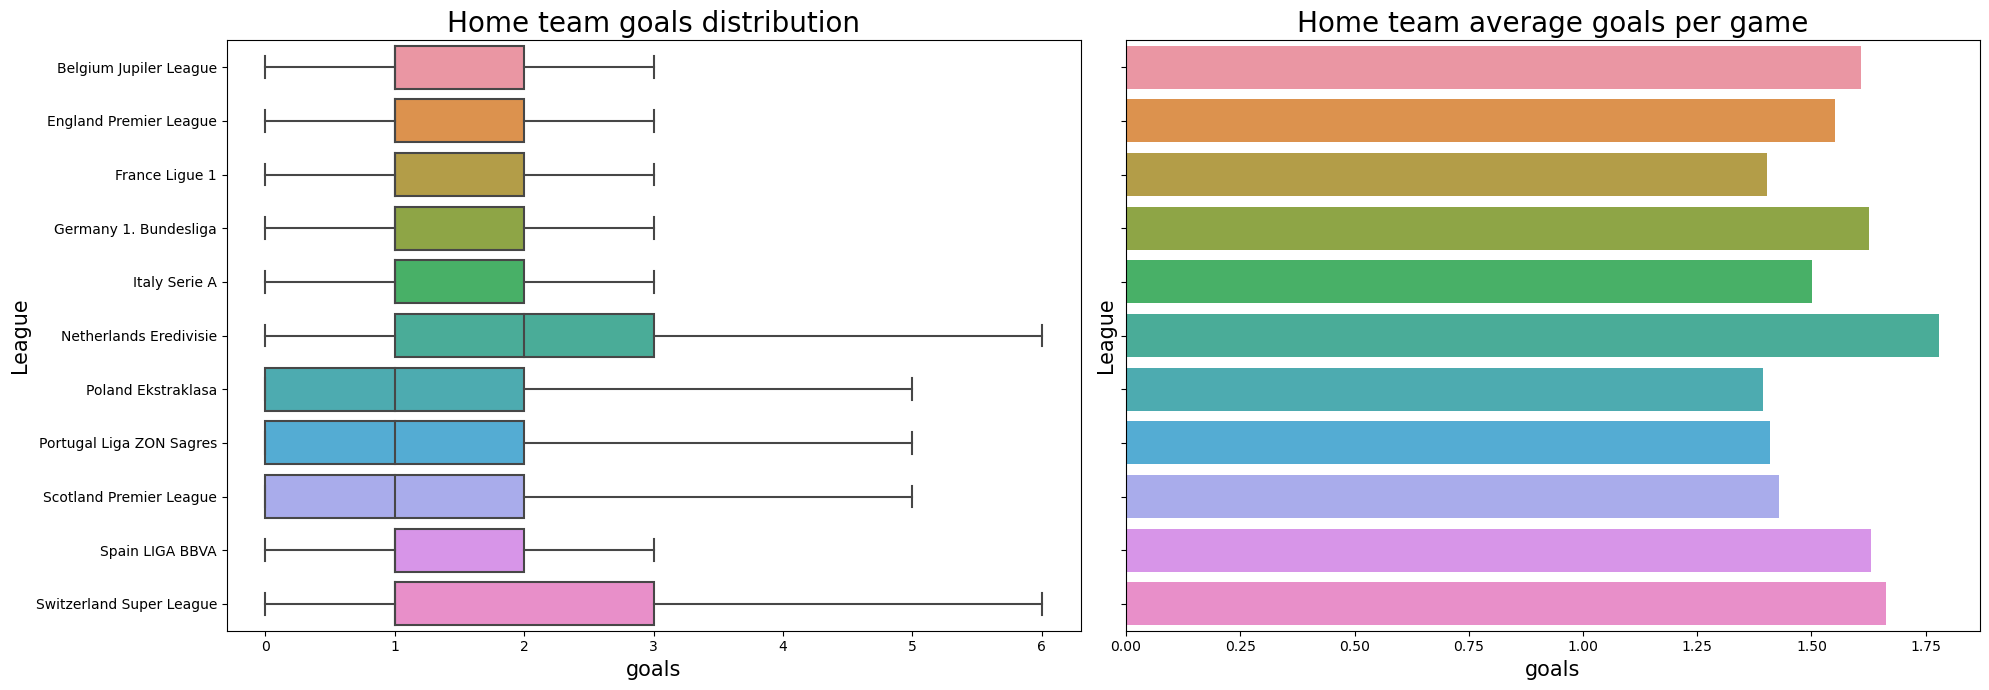

In [730]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7), sharey = True)

sns.boxplot(data = df_match_result, x = "home_team_goal", y = "league", showfliers = False, ax = axes[0])
axes[0].set_xlabel("goals", fontsize = 15)
axes[0].set_ylabel("League", fontsize = 15)
axes[0].set_title("Home team goals distribution", fontsize = 20)

sns.barplot(df_match_result.groupby("league").home_team_goal.describe().reset_index(), x = "mean", y = "league")
axes[1].set_xlabel("goals", fontsize = 15)
axes[1].set_ylabel("League", fontsize = 15)
axes[1].set_title("Home team average goals per game", fontsize = 20)

plt.tight_layout()

- Looking at the distribution of the number of home team goals by league over 8 seasons, it can be seen that the Dutch and Swiss leagues have more home team goals than other leagues.
- Average Home team goals per game are around 1.5 across all leagues.
- In the case of the France, Poland, Portugal, and Scotland, home team average goals per game are slightly lower than other leagues.
- In the case of the Netherland, home team average goals per game are slightly higher than other leagues.

In [718]:
df_match_result.groupby("league").away_team_goal.describe()

,count,mean,std,min,25%,50%,75%,max
league,,,,,,,,
Belgium Jupiler League,1728.0,1.192130,1.125123,0.0,0.0,1.0,2.0,7.0
England Premier League,3040.0,1.159539,1.144629,0.0,0.0,1.0,2.0,6.0
France Ligue 1,3040.0,1.040132,1.059765,0.0,0.0,1.0,2.0,9.0
Germany 1. Bundesliga,2448.0,1.274918,1.200392,0.0,0.0,1.0,2.0,8.0
Italy Serie A,3017.0,1.116009,1.078392,0.0,0.0,1.0,2.0,7.0
Netherlands Eredivisie,2448.0,1.301062,1.240430,0.0,0.0,1.0,2.0,6.0
Poland Ekstraklasa,1920.0,1.030208,1.046159,0.0,0.0,1.0,2.0,6.0
Portugal Liga ZON Sagres,2052.0,1.126218,1.155469,0.0,0.0,1.0,2.0,6.0
Scotland Premier League,1824.0,1.204496,1.151384,0.0,0.0,1.0,2.0,6.0


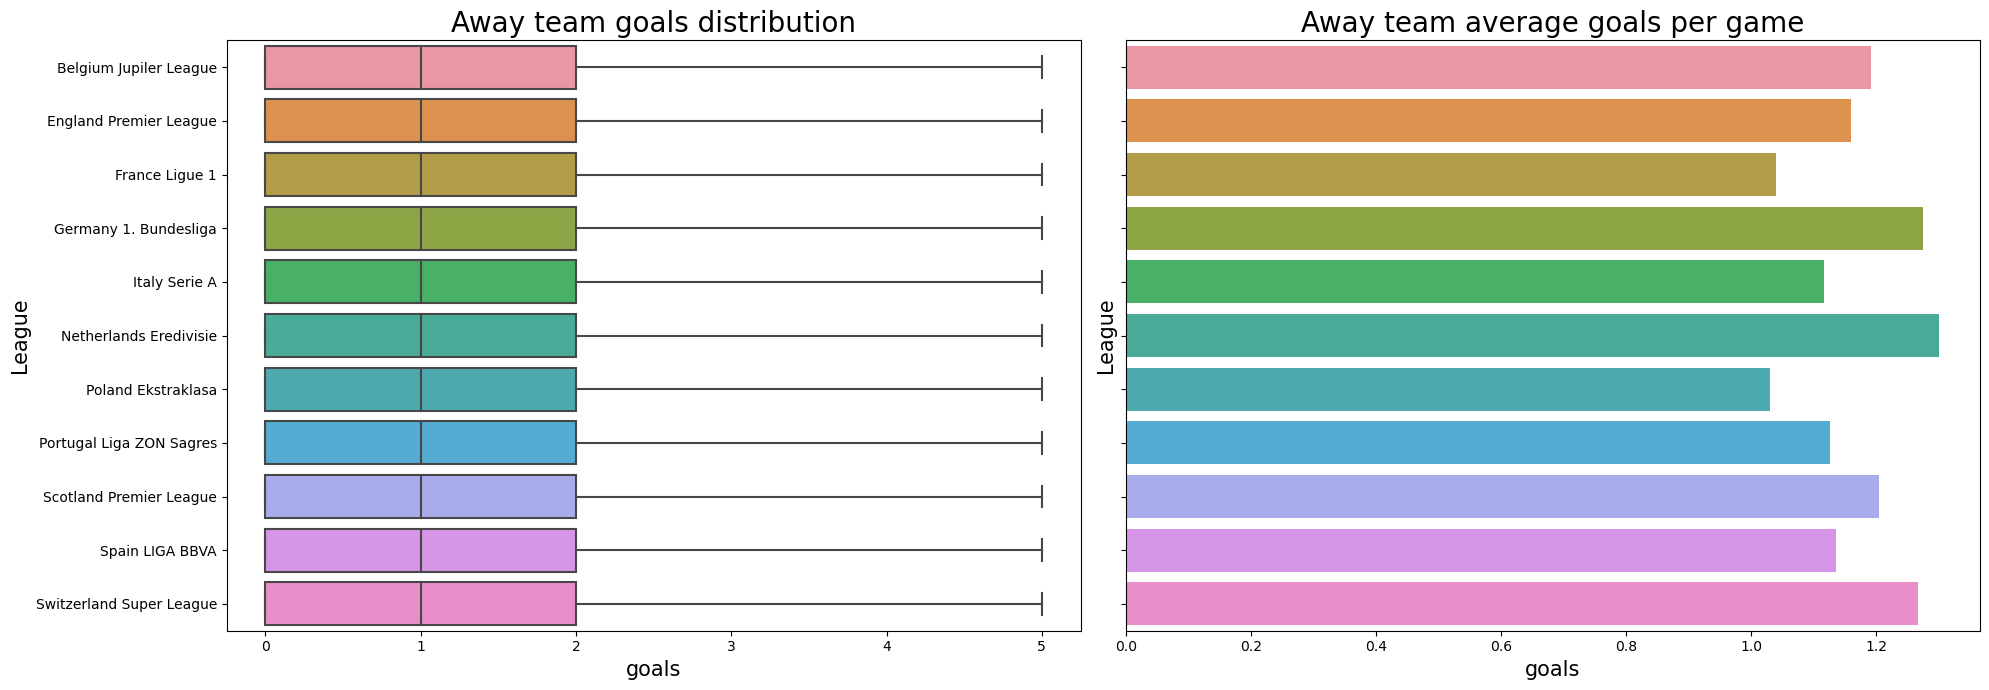

In [732]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7), sharey = True)

sns.boxplot(data = df_match_result, x = "away_team_goal", y = "league", showfliers = False, ax = axes[0])
axes[0].set_xlabel("goals", fontsize = 15)
axes[0].set_ylabel("League", fontsize = 15)
axes[0].set_title("Away team goals distribution", fontsize = 20)

sns.barplot(df_match_result.groupby("league").away_team_goal.describe().reset_index(), x = "mean", y = "league")
axes[1].set_xlabel("goals", fontsize = 15)
axes[1].set_ylabel("League", fontsize = 15)
axes[1].set_title("Away team average goals per game", fontsize = 20)

plt.tight_layout()

- The away team's goals distribution over the eight seasons shows a nearly identical distribution across all leagues compared to the home team's goals distributions.
- Away teams score around 1.1 goals per game on average across all leagues.
- In the case of the France and the Poland, away team average goals per game are slightly lower than other leagues.  
- In the case of the Germany, Netherlands, and Switzeland, away team average goals per game are slightly higher than other leagues.

- Average home and away team goals per game vary by league.
- Therefore, the influence of a player who scores more home goals and a player who scores more away goals may have different effects on the match result for each league.
- Therefore, let's use the cumulative number of home team goals and cumulative number of away team goals for each player as variables later. 


### Home away goals by team

- Will do later.

### Match results

- Based on home_team_goal and away_team_goal varialbes, we can make match result varialbe.
    - home_team_goal > away_team_goal: home_win
    - home_team_goal = away_team_goal: draw
    - home_team_goal < away_team_goal: away_win
- This match result is the variable that we want to predict.

In [757]:
home_win_bool = (df_match_result.home_team_goal > df_match_result.away_team_goal)
draw_bool = (df_match_result.home_team_goal == df_match_result.away_team_goal)
away_win_bool = (df_match_result.home_team_goal < df_match_result.away_team_goal)


In [759]:
df_match_result.loc[home_win_bool, "match_result"] = "home_win"
df_match_result.loc[draw_bool, "match_result"] = "draw"
df_match_result.loc[away_win_bool, "match_result"] = "away_win"

In [800]:
df_match_result.match_result.value_counts()

home_win    11917
away_win     7466
draw         6596
Name: match_result, dtype: int64

Text(0, 0.5, 'Count')

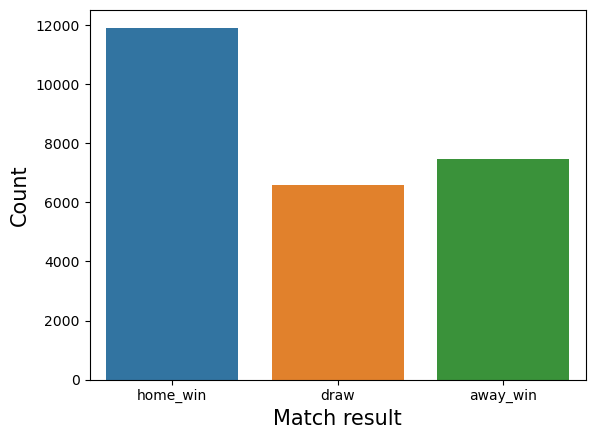

In [802]:
sns.countplot(x = df_match_result.match_result,
              order = ["home_win", "draw", "away_win"])
plt.xlabel("Match result", fontsize = 15)
plt.ylabel("Count", fontsize = 15)

- Out of a total of 25979 matches
    - About 45% (11917 / 25979) were won by the home team
    - About 25% (6596 / 25979) were draw
    - About 29% (7466 / 25979) were won by the away team

### Match results by league

In [810]:
df_match_result_pivot = df_match_result.pivot_table(index = "league", columns = "match_result", values = "stage", aggfunc = "count")
df_match_result_pivot["sum"] = df_match_result_pivot.sum(axis = 1)

match_result_prop = df_match_result_pivot[["home_win", "away_win", "draw"]].divide(df_match_result_pivot["sum"], axis = 0).multiply(100)



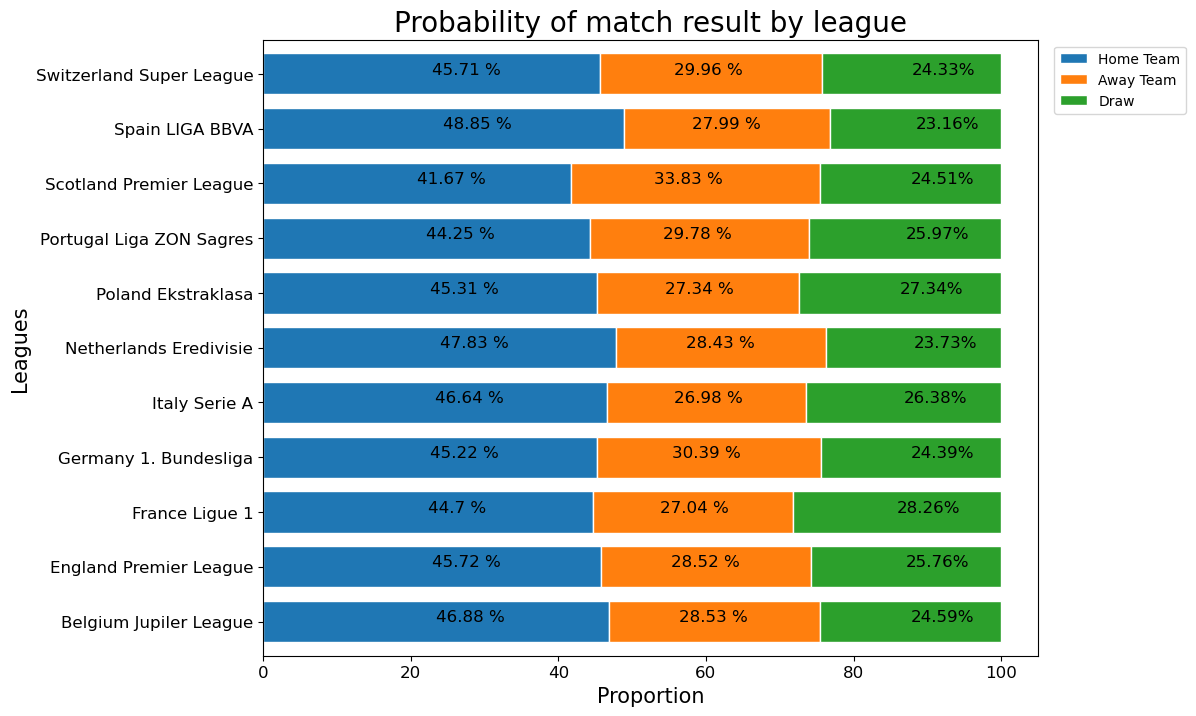

In [811]:
ax = match_result_prop.plot.barh(stacked = True, figsize = (10, 8), width = 0.75, edgecolor = 'w')
ax.legend(['Home Team','Away Team','Draw'], bbox_to_anchor = (1.2, 1), loc = 'upper right')
plt.title('Probability of match result by league', fontsize = 20)
plt.xlabel('Proportion',fontsize = 15)
plt.ylabel('Leagues', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for  i, j in enumerate(match_result_prop.index):
    plt.text(match_result_prop.loc[j, 'home_win']/2, i, str(round(match_result_prop.loc[j, 'home_win'], 2)) + ' %', fontsize = 12)
    plt.text(match_result_prop.loc[j, 'home_win'] + match_result_prop.loc[j,'away_win']/3, i, str(round(match_result_prop.loc[j,'away_win'], 2)) + ' %',fontsize = 12)
    plt.text(match_result_prop.loc[j, 'home_win'] + match_result_prop.loc[j,'away_win']+ match_result_prop.loc[j, 'draw']/2, i, str(round(match_result_prop.loc[j, 'draw'], 2)) + '%', fontsize = 12)


- Even by league, 
    - the home team wins is about 45% 
    - the away team wins about 28% 
    - the draw is about 25%.
- The distribution of the home team wins, away team wins, and draws in every league is approximately same.
- So, if we just predict all matche result as home team win, then we can achieve the accuracy about 45%. This can be the baseline accuracy, that will be compared with our trained model later.

- The country with the highest proportion of home team wins is Spain.
- The country with the lowest proportion of home team wins is Scotland
- The country with the highest proportion of away team wins is Scotland.
- The country with the lowest proportion of away team wins is Italy.
- The country with the highest proportion of draw is France.
- The country with the lowest proportion of draw is Spain.


### 2.2.4. Betting information

In [816]:
betting_col = ["match_api_id", 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 
               'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 
               'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

In [843]:
df_betting = df_match[betting_col]

- Odds are an indication of how likely an outcome is to occur. For very likely outcomes, the odds are lower, meaning the bookmaker is expecting this outcome, and as such, a lower payout is attached to a winning bet.

- Before the last letter means betting site. There are 10 betting sites.
- Last letter
    - "H": Home win odds
    - "D": Draw odds
    - "A": Away win odds
- So there are 10 betting sites * 3 last letter = 30 betting information.

<AxesSubplot:>

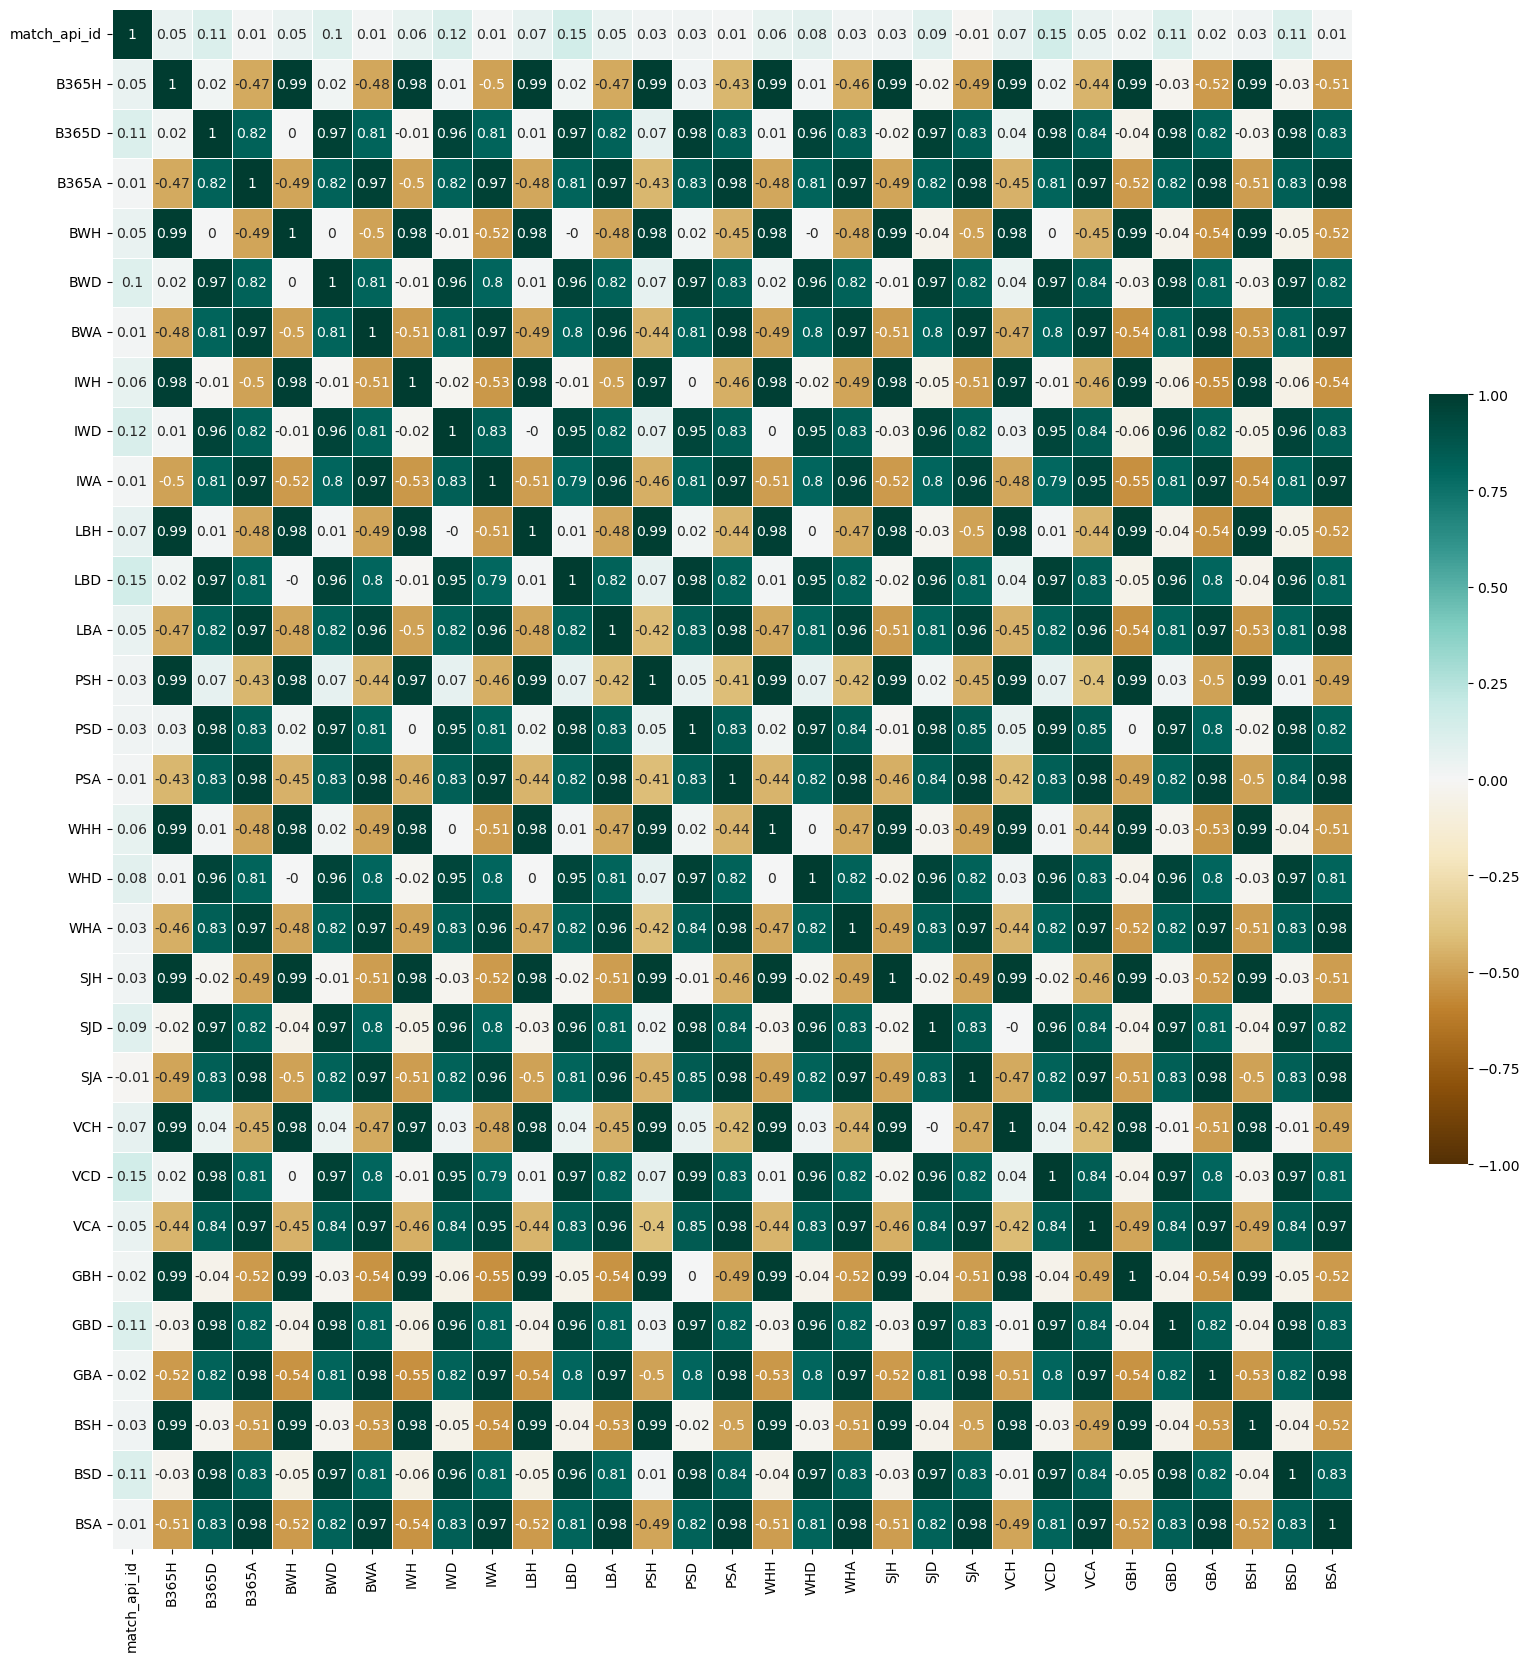

In [844]:
plt.figure(figsize = (20, 20))

corr = round(df_betting.corr(), 2)

sns.heatmap(corr, annot = True, cmap = "BrBG", vmin = -1, vmax = 1, 
            linewidths = 0.5, cbar_kws = {"shrink" : 0.5})

- Home team win odd has a correlation close to 1 between different sites.
- Draw and away team win odd have a correlation close to 1 between different sites.
- That is, there are too many similar information. We need to reduce the betting related variables.

<AxesSubplot:>

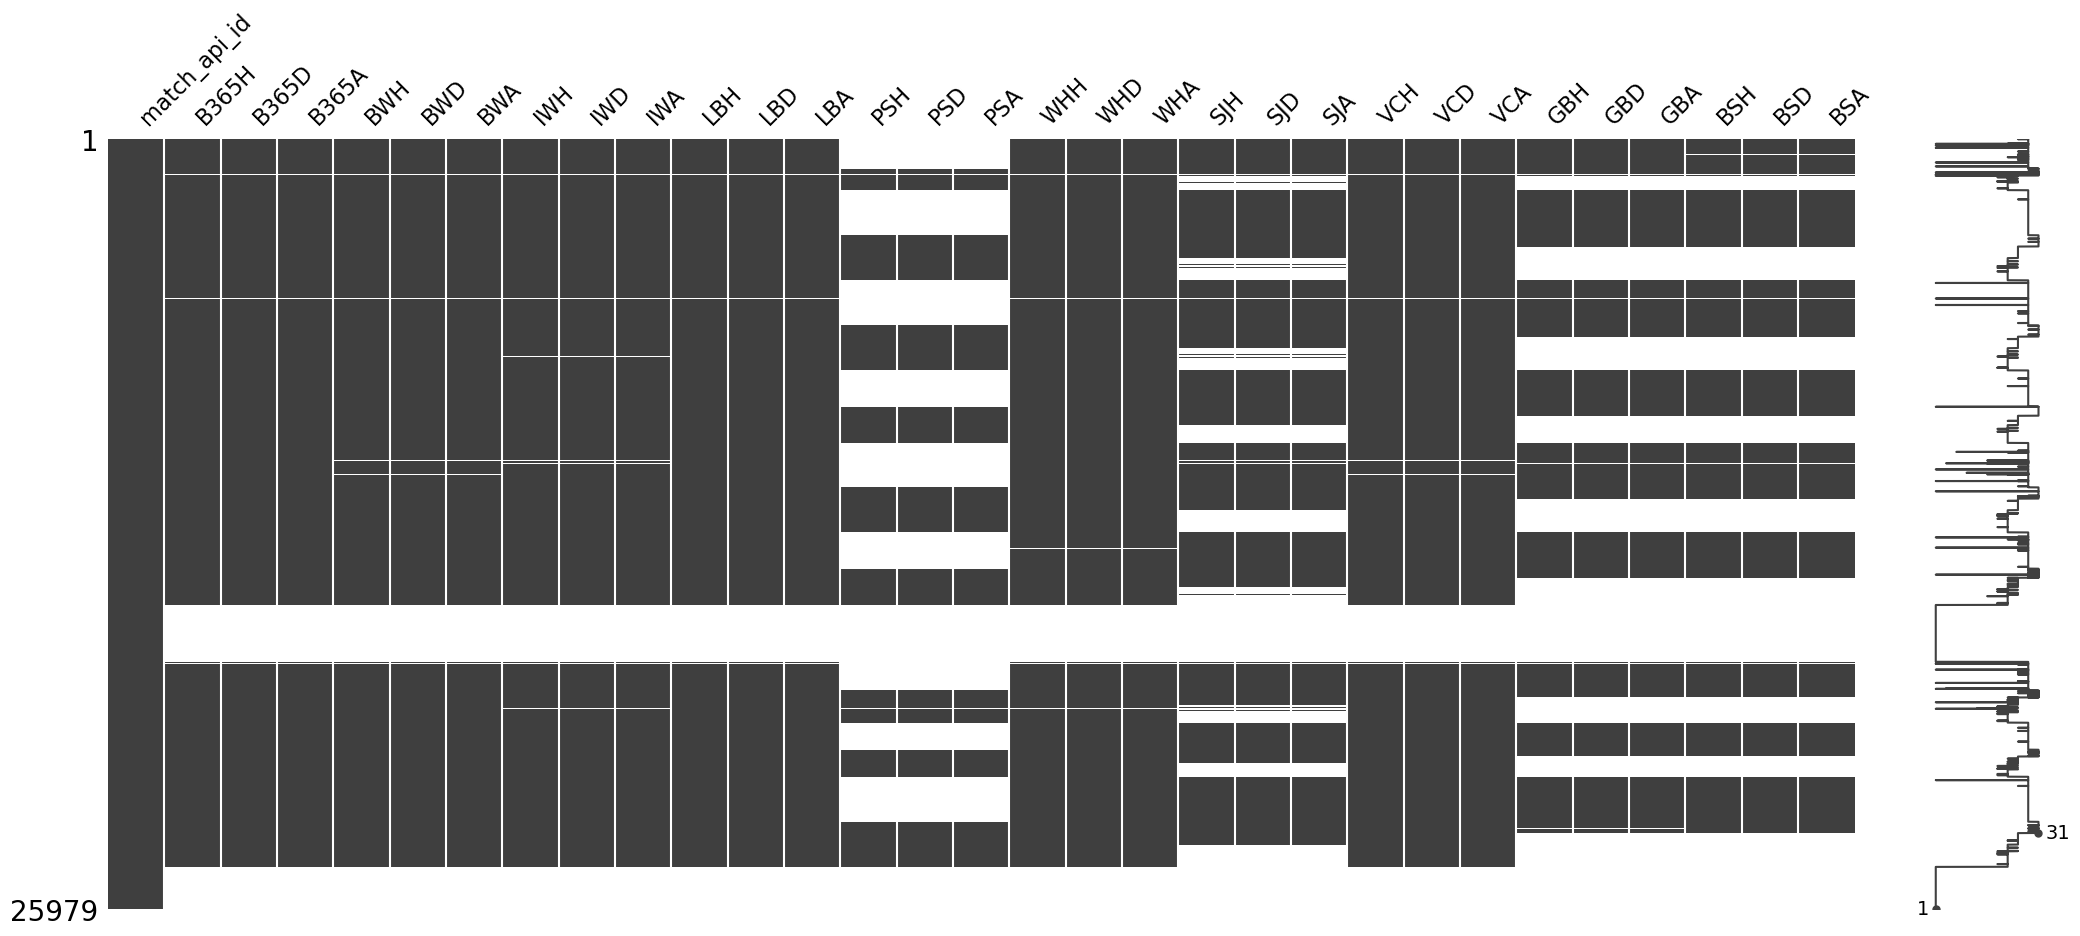

In [845]:
msno.matrix(df_betting)

In [850]:
df_betting.isna().sum().sort_values(ascending = False)

PSA             14811
PSH             14811
PSD             14811
BSD             11818
BSH             11818
BSA             11818
GBH             11817
GBA             11817
GBD             11817
SJH              8882
SJA              8882
SJD              8882
IWD              3459
IWA              3459
IWH              3459
LBH              3423
LBD              3423
LBA              3423
VCH              3411
VCD              3411
VCA              3411
WHD              3408
WHH              3408
WHA              3408
BWA              3404
BWH              3404
BWD              3404
B365H            3387
B365A            3387
B365D            3387
match_api_id        0
dtype: int64

- First, let's exclude the betting variables with more than 4,000 missing values.

In [853]:
target_cols = df_betting.isna().sum()[df_betting.isna().sum() > 4000].index.values

In [855]:
df_betting = df_betting.drop(target_cols, axis = 1)

<AxesSubplot:>

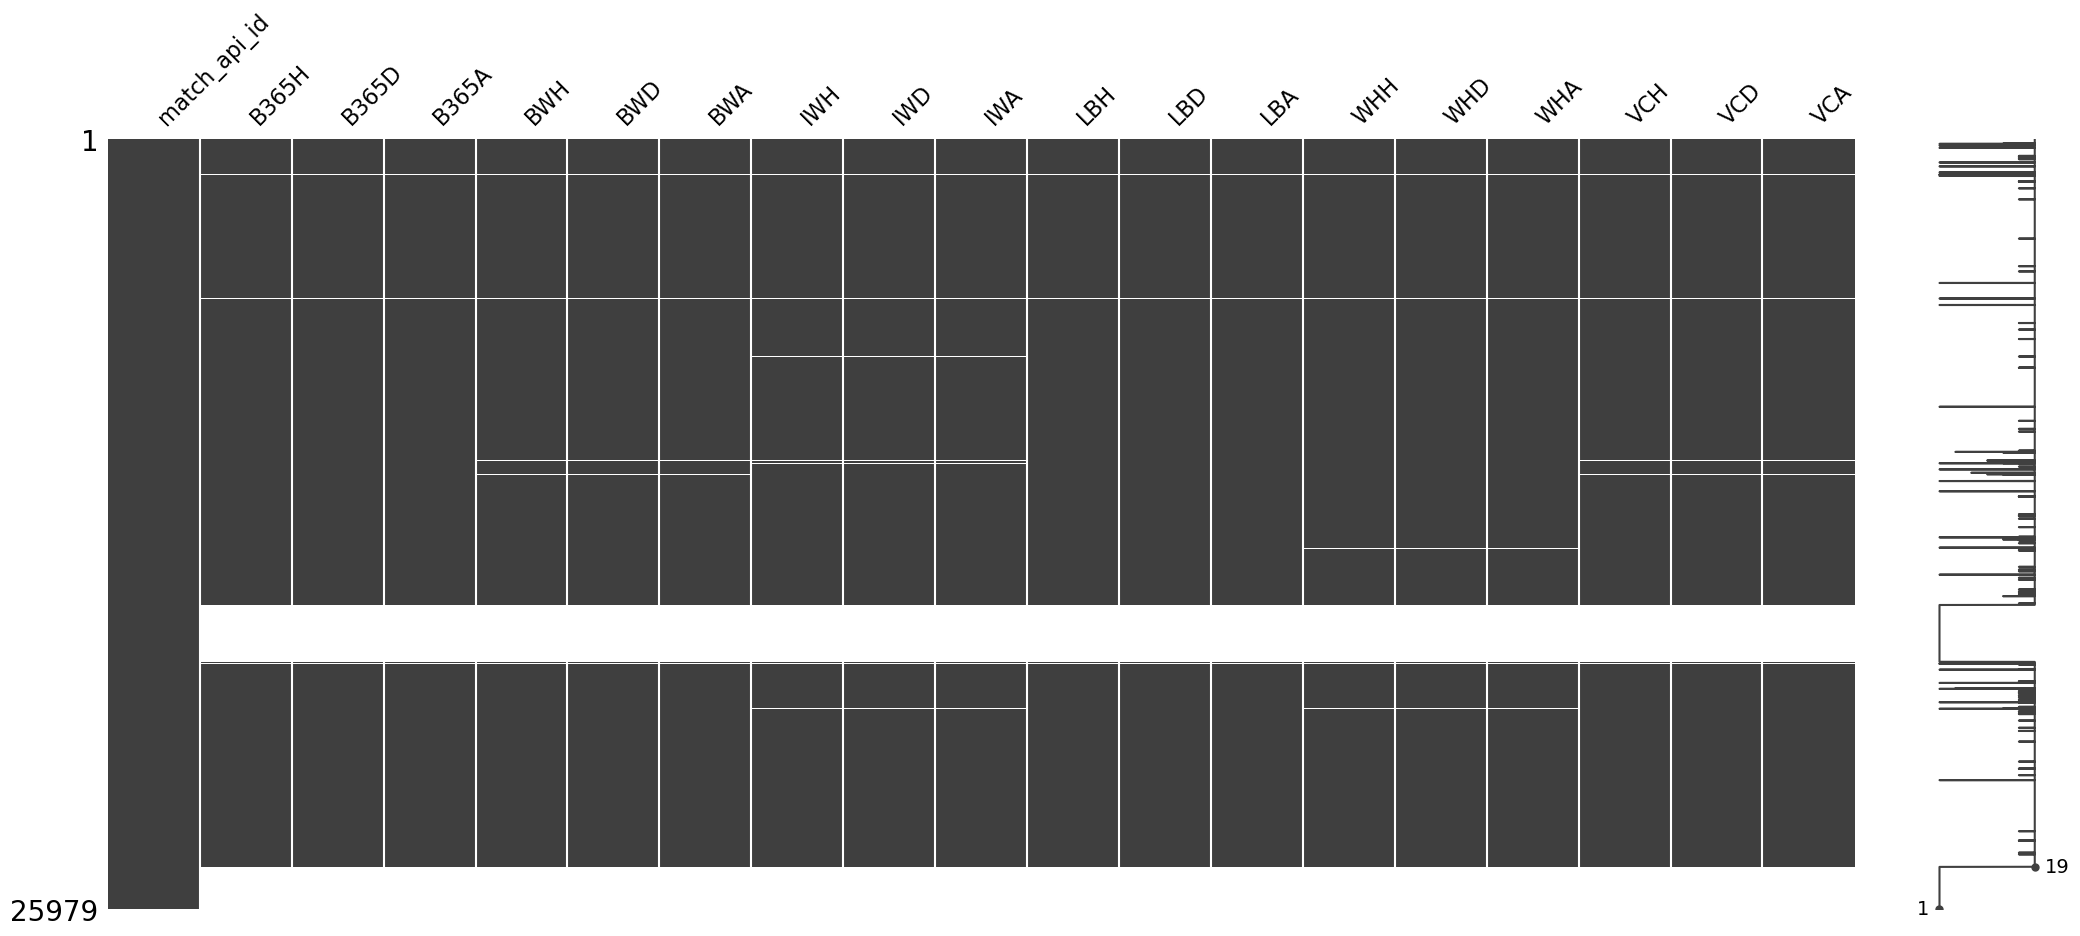

In [856]:
msno.matrix(df_betting)

- If there is a mssing value in the B356H, then all betting variables have mssing value.

In [868]:
df_betting[df_betting.B365H.isna()].shape

(3387, 24)

- There are 3387 cases that all betting variables have mssing values.
- Simply drop these matches.

In [876]:
df_betting = df_betting[~df_betting.B365H.isna()]

- If th last letter is
    - "H": Home win odds
    - "D": Draw odds
    - "A": Awa win odds
- That is, if the last letter is same, they have same information between different sites.
- So let's use summary statistics as follow:
    - last letter "H" betting odds: min, max, mean, std 
    - last letter "D" betting odds: min, max, mean, std 
    - last letter "A" betting odds: min, max, mean, std 

In [878]:
H_odds = ["B365H", "BWH", "IWH", "LBH", "WHH", "VCH"]
D_odds = ["B365D", "BWD", "IWD", "LBD", "WHD", "VCD"]
A_odds = ["B365A", "BWA", "IWA", "LBA", "WHA", "VCA"]

In [884]:
H_odds_stat = pd.DataFrame({"H_odd_min": df_betting[H_odds].min(axis = 1),
                            "H_odd_max": df_betting[H_odds].max(axis = 1),
                            "H_odd_mean": df_betting[H_odds].mean(axis = 1),
                            "H_odd_std": df_betting[H_odds].min(axis = 1)})

In [885]:
D_odds_stat = pd.DataFrame({"D_odd_min": df_betting[D_odds].min(axis = 1),
                            "D_odd_max": df_betting[D_odds].max(axis = 1),
                            "D_odd_mean": df_betting[D_odds].mean(axis = 1),
                            "D_odd_std": df_betting[D_odds].min(axis = 1)})

In [886]:
A_odds_stat = pd.DataFrame({"A_odd_min": df_betting[A_odds].min(axis = 1),
                            "A_odd_max": df_betting[A_odds].max(axis = 1),
                            "A_odd_mean": df_betting[A_odds].mean(axis = 1),
                            "A_odd_std": df_betting[A_odds].min(axis = 1)})

In [890]:
df_betting_stat = pd.concat([df_betting.match_api_id, H_odds_stat, D_odds_stat, A_odds_stat], axis = 1)

In [891]:
df_betting_stat

,match_api_id,H_odd_min,H_odd_max,H_odd_mean,H_odd_std,D_odd_min,D_odd_max,D_odd_mean,D_odd_std,A_odd_min,A_odd_max,A_odd_mean,A_odd_std
0,492473,1.65,1.85,1.746667,1.65,3.2,3.4,3.325000,3.2,3.50,5.00,4.213333,3.50
1,492474,1.80,2.00,1.896667,1.80,3.2,3.3,3.241667,3.2,3.25,3.95,3.566667,3.25
2,492475,2.35,2.60,2.455000,2.35,3.1,3.3,3.233333,3.1,2.30,2.75,2.525000,2.30
3,492476,1.40,1.45,1.428333,1.40,3.6,4.0,3.791667,3.6,6.00,7.50,6.550000,6.00
4,492477,4.00,5.00,4.450000,4.00,3.3,3.5,3.416667,3.3,1.60,1.72,1.670000,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,2030167,1.57,1.65,1.591667,1.57,3.3,4.0,3.758333,3.3,4.90,7.00,6.400000,4.90
24553,2030168,2.20,2.38,2.288333,2.20,3.1,3.4,3.208333,3.1,3.10,3.40,3.241667,3.10
24554,2030169,1.50,1.60,1.550000,1.50,3.5,4.2,3.900000,3.5,5.40,7.00,6.566667,5.40
24555,2030170,2.30,2.40,2.341667,2.30,3.1,3.4,3.250000,3.1,2.75,3.30,3.083333,2.75


<AxesSubplot:>

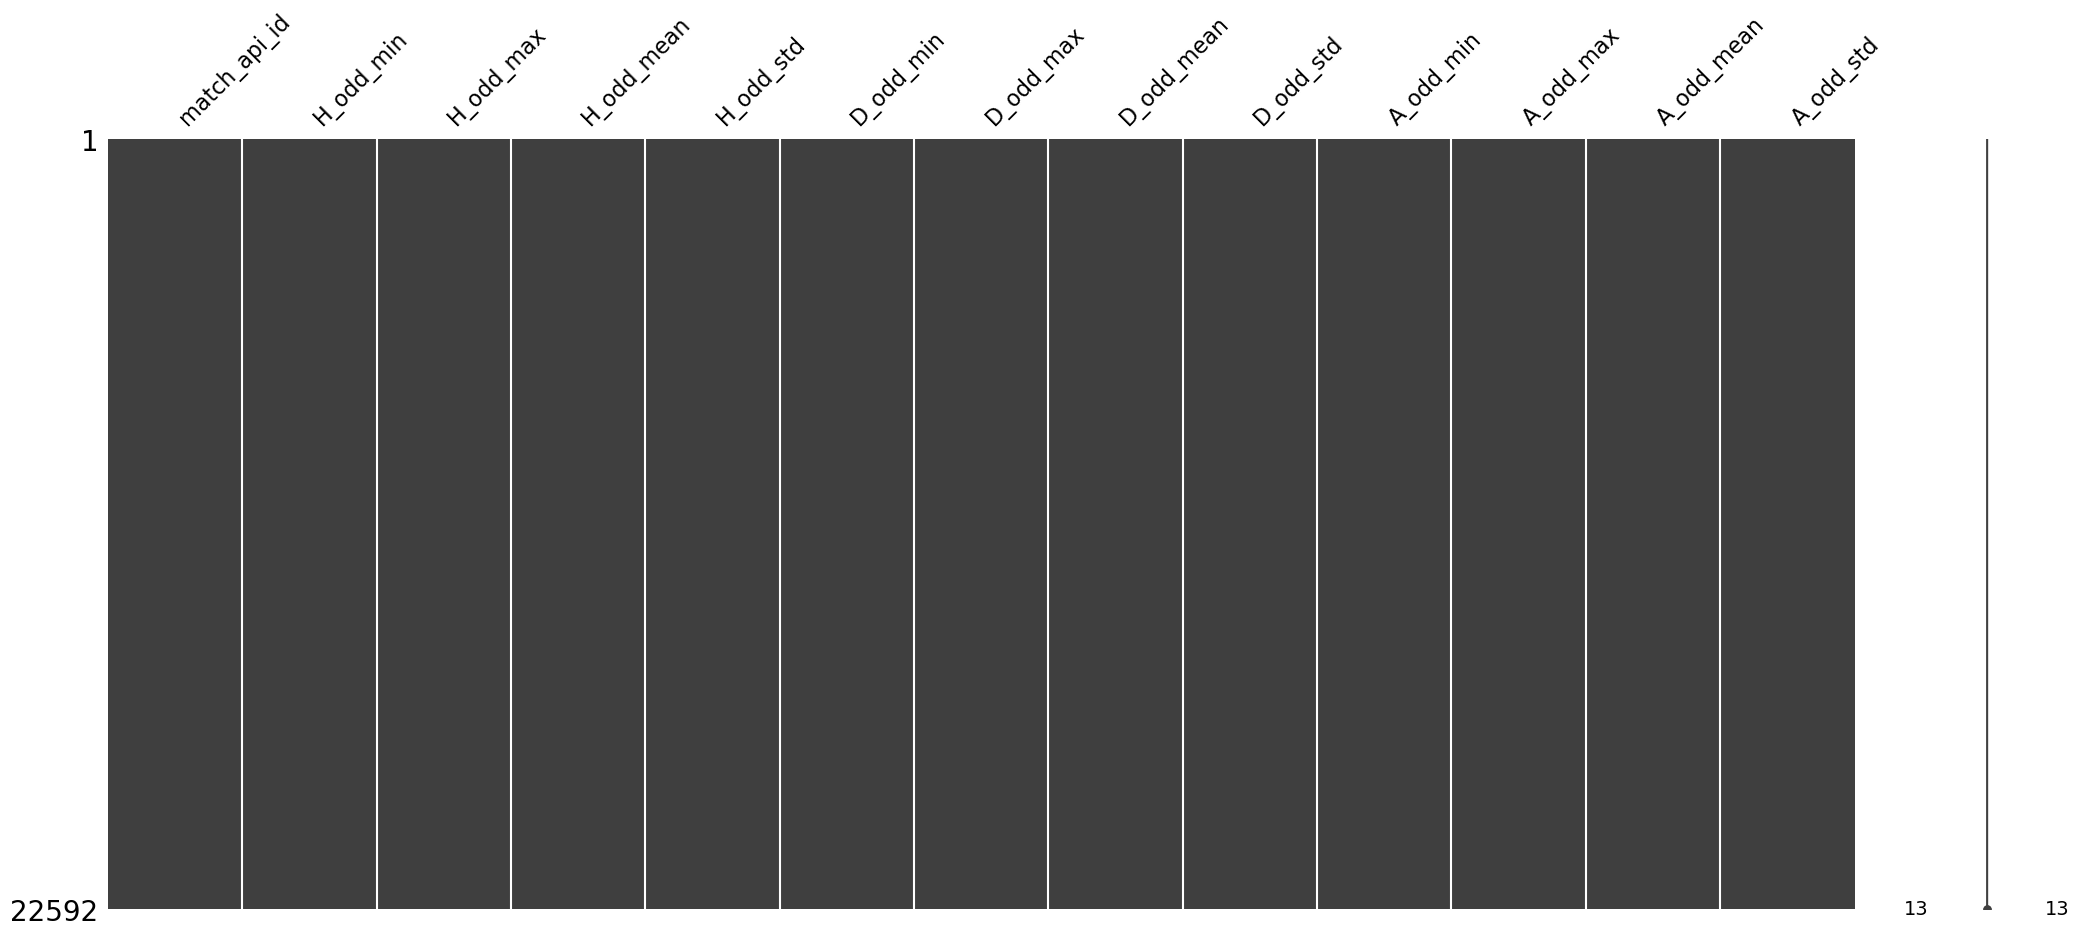

In [892]:
msno.matrix(df_betting_stat)

- Finally, we have 3 result (home win, draw, away win) * 4 summary statistics (min, max, mean, std) = 12 betting related variables.

## 2.3. Team related data:  Country, League, Team, Team_Attributes table

- Will do later

# 3. Modeling

- We have 4 kinds of variable sets 
    - variable set 1: player attributes columns
    - Variable set 2: betting information columns
    - variable set 3: team attributes columns (will do later)
    - variable set 4: in-game information columns (will do later)

- By using each variable sets, let's predict the match result and compare the result.

## 3.1. Variable set 1: player attributes columns

- In the match data, we have the information of 22 players id from the each team.
- Since we will merge the player attributes to the match data, there are too many columns: 22 players * 35 attributes = 770 columns.


In [947]:
df_player_grouped_num_attr = df_player_all_imputed[player_num_attr].drop(["date", "height", "weight", "age"], axis = 1).groupby("player_api_id").mean()
df_player_grouped_num_attr

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_api_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2625,60.142857,61.142857,50.142857,47.285714,46.285714,56.500000,38.000000,54.142857,50.000000,49.928571,65.571429,59.142857,66.857143,63.285714,66.428571,49.714286,66.214286,66.714286,58.714286,77.285714,55.785714,56.857143,71.285714,62.071429,50.357143,55.285714,61.928571,62.928571,63.857143,56.571429,12.428571,12.857143,19.071429,10.357143,10.428571
2752,69.380952,70.380952,36.428571,37.428571,75.333333,54.809524,20.428571,44.857143,30.428571,18.857143,59.571429,55.571429,41.619048,42.190476,43.333333,60.857143,44.571429,57.428571,56.523810,60.904762,82.238095,19.571429,80.285714,71.428571,31.428571,52.428571,35.428571,71.095238,70.666667,65.571429,11.095238,6.095238,7.095238,9.095238,15.095238
2768,69.285714,70.571429,42.238095,42.761905,66.666667,64.714286,28.761905,40.238095,51.761905,20.047619,57.000000,56.380952,56.952381,58.904762,58.047619,69.809524,60.190476,38.761905,76.904762,59.285714,67.428571,19.428571,62.761905,74.714286,44.190476,57.761905,31.904762,71.666667,70.619048,79.714286,10.761905,15.904762,22.714286,15.142857,12.095238
2770,71.133333,73.533333,61.866667,67.666667,67.800000,72.533333,67.133333,75.066667,79.800000,68.666667,70.266667,76.733333,62.200000,59.800000,62.600000,65.933333,61.266667,68.333333,57.133333,51.000000,62.600000,73.000000,56.800000,44.933333,64.533333,71.600000,63.933333,30.200000,37.533333,25.000000,8.666667,15.666667,27.200000,16.333333,17.000000
2790,70.200000,75.800000,70.000000,37.400000,55.200000,68.000000,43.000000,60.800000,67.000000,55.400000,69.800000,66.800000,70.800000,71.200000,65.000000,69.200000,67.000000,46.400000,61.000000,70.400000,71.000000,42.400000,68.400000,63.400000,60.600000,60.000000,55.400000,74.600000,74.600000,69.000000,8.000000,17.000000,59.000000,16.600000,17.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744907,51.909091,65.909091,42.454545,44.454545,47.454545,59.454545,42.454545,56.454545,46.454545,43.454545,58.454545,55.454545,66.000000,64.000000,61.000000,53.454545,74.000000,50.454545,63.000000,54.000000,49.909091,38.454545,36.454545,22.454545,48.454545,51.454545,52.454545,39.454545,48.454545,49.454545,8.454545,13.454545,12.454545,11.454545,8.454545
746419,59.000000,66.000000,55.000000,28.000000,50.000000,35.000000,29.000000,67.000000,37.000000,39.000000,35.000000,55.000000,77.000000,76.000000,70.000000,60.000000,74.000000,29.000000,55.000000,63.000000,46.000000,27.000000,59.000000,53.000000,55.000000,40.000000,43.000000,55.000000,69.000000,62.000000,7.000000,10.000000,7.000000,9.000000,9.000000
748432,58.000000,68.000000,48.000000,26.000000,57.000000,49.000000,24.000000,41.000000,39.000000,20.000000,41.000000,42.000000,64.000000,68.000000,50.000000,48.000000,52.000000,46.000000,68.000000,50.000000,67.000000,25.000000,52.000000,55.000000,38.000000,36.000000,45.000000,63.000000,69.000000,68.000000,8.000000,8.000000,12.000000,12.000000,6.000000


<AxesSubplot:>

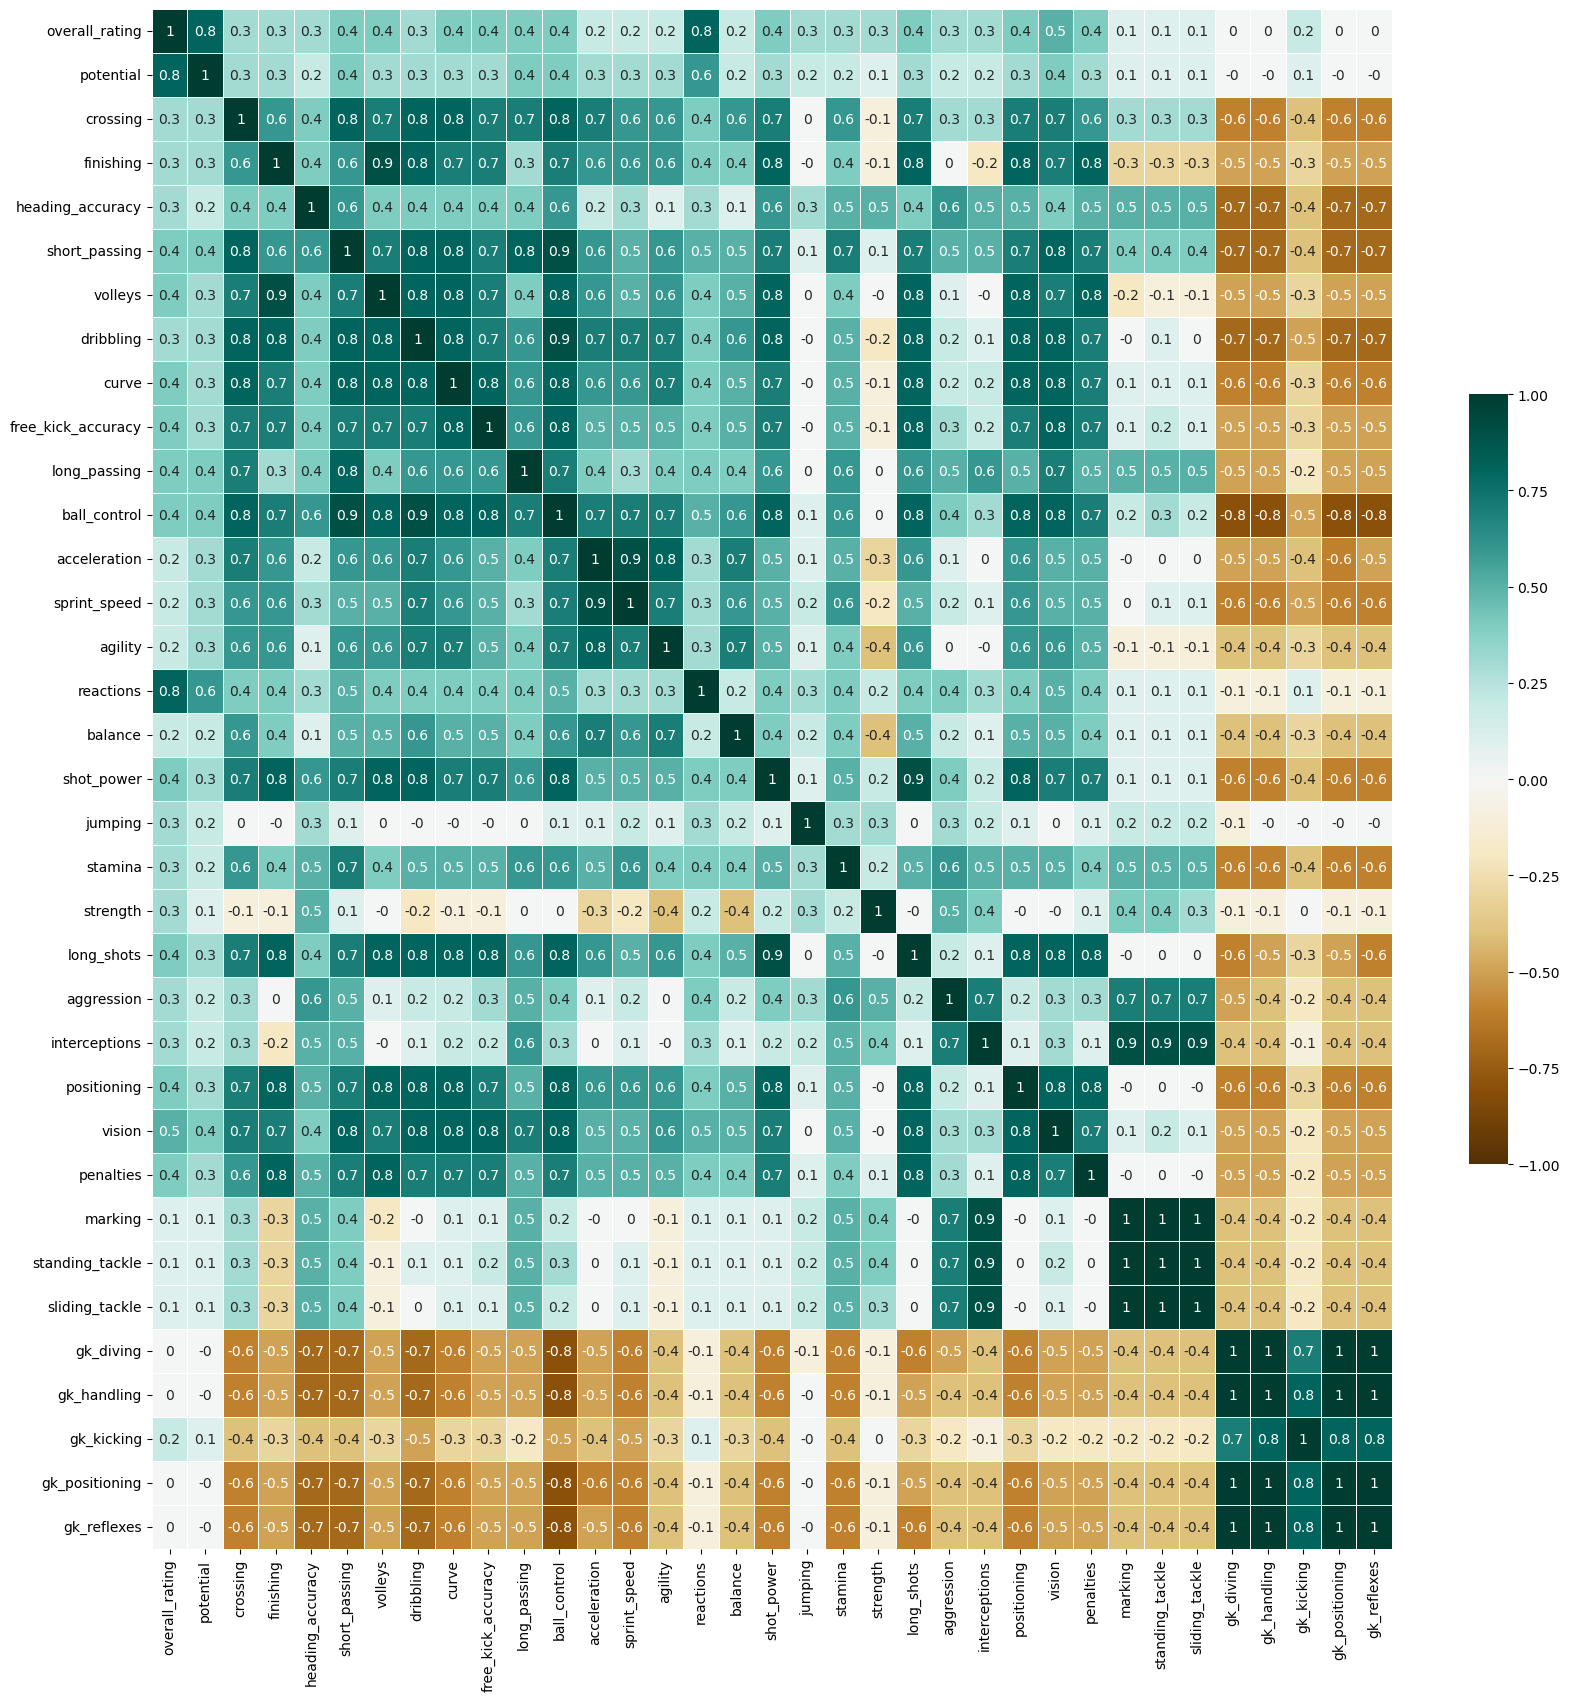

In [948]:
plt.figure(figsize = (20, 20))

corr = round(df_player_grouped_num_attr.corr(), 1)

sns.heatmap(corr, annot = True, cmap = "BrBG", vmin = -1, vmax = 1, 
            linewidths = 0.5, cbar_kws = {"shrink" : 0.5})

- Aslo, correlations between player numerical attributes are very high.

- So, I will use the PCA to reduce the dimension of the numerical player attributes.

### Split the data

- To prevent a data leakage, first divdie the data into train test sets and then do PCA for the train set.
- I set the the last season (2015/2016 seasons) as the test set, which is about 13% of the total matches.

In [1293]:
test_match_api_id = df_match[(df_match.season == "2015/2016")].match_api_id

In [1294]:
train_match_api_id = df_match[~df_match.match_api_id.isin(test_match_api_id)].match_api_id

### PCA

- Check the season start month to exclude the player attributes information measured before the 2015 season.

In [1297]:
for season in ["2015/2016"]:
    print(f"== Season: {season}")
    print(df_match[df_match.season == season].sort_values("date").groupby(["league_id", "season"]).min().date)

== Season: 2015/2016
league_id  season   
1          2015/2016    2015-07-24 00:00:00
1729       2015/2016    2015-08-08 00:00:00
4769       2015/2016    2015-08-07 00:00:00
7809       2015/2016    2015-08-14 00:00:00
10257      2015/2016    2015-08-22 00:00:00
13274      2015/2016    2015-08-08 00:00:00
15722      2015/2016    2015-07-17 00:00:00
17642      2015/2016    2015-08-14 00:00:00
19694      2015/2016    2015-08-01 00:00:00
21518      2015/2016    2015-08-21 00:00:00
24558      2015/2016    2015-07-18 00:00:00
Name: date, dtype: object


- We can use the player attributes information measured before the 2015-07-17

In [1298]:
player_cutoff_date = pd.to_datetime("2015-07-17")
player_cutoff_date

Timestamp('2015-07-17 00:00:00')

In [1299]:
player_cutoff_bool = pd.to_datetime(df_player_all_imputed.date) < player_cutoff_date

In [1300]:
df_player_grouped_num_attr = df_player_all_imputed.loc[player_cutoff_bool, player_num_attr].drop(["date", "height", "weight", "age"], axis = 1).groupby("player_api_id").mean()
df_player_grouped_num_attr

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_api_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2625,60.142857,61.142857,50.142857,47.285714,46.285714,56.500000,38.000000,54.142857,50.000000,49.928571,65.571429,59.142857,66.857143,63.285714,66.428571,49.714286,66.214286,66.714286,58.714286,77.285714,55.785714,56.857143,71.285714,62.071429,50.357143,55.285714,61.928571,62.928571,63.857143,56.571429,12.428571,12.857143,19.071429,10.357143,10.428571
2752,69.105263,70.210526,36.157895,37.157895,74.631579,54.368421,20.157895,45.263158,30.157895,18.842105,59.421053,55.421053,42.578947,42.526316,44.315789,60.526316,45.157895,57.157895,56.684211,60.789474,81.947368,19.526316,79.894737,71.473684,31.157895,52.157895,35.157895,71.000000,70.315789,65.421053,11.000000,6.000000,7.000000,9.000000,15.000000
2768,67.562500,69.250000,41.687500,42.062500,65.000000,61.562500,28.062500,39.062500,52.312500,19.437500,56.062500,54.312500,58.687500,60.687500,58.062500,67.562500,59.937500,38.062500,76.250000,64.000000,66.000000,19.250000,62.062500,72.812500,45.500000,57.062500,36.875000,69.812500,68.687500,80.062500,10.375000,16.187500,25.750000,15.500000,12.750000
2770,71.133333,73.533333,61.866667,67.666667,67.800000,72.533333,67.133333,75.066667,79.800000,68.666667,70.266667,76.733333,62.200000,59.800000,62.600000,65.933333,61.266667,68.333333,57.133333,51.000000,62.600000,73.000000,56.800000,44.933333,64.533333,71.600000,63.933333,30.200000,37.533333,25.000000,8.666667,15.666667,27.200000,16.333333,17.000000
2790,70.200000,75.800000,70.000000,37.400000,55.200000,68.000000,43.000000,60.800000,67.000000,55.400000,69.800000,66.800000,70.800000,71.200000,65.000000,69.200000,67.000000,46.400000,61.000000,70.400000,71.000000,42.400000,68.400000,63.400000,60.600000,60.000000,55.400000,74.600000,74.600000,69.000000,8.000000,17.000000,59.000000,16.600000,17.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744907,51.000000,65.000000,42.000000,44.000000,47.000000,59.000000,42.000000,56.000000,46.000000,43.000000,58.000000,55.000000,66.000000,64.000000,61.000000,53.000000,74.000000,50.000000,63.000000,54.000000,49.000000,38.000000,36.000000,22.000000,48.000000,51.000000,52.000000,39.000000,48.000000,49.000000,8.000000,13.000000,12.000000,11.000000,8.000000
746419,59.000000,66.000000,55.000000,28.000000,50.000000,35.000000,29.000000,67.000000,37.000000,39.000000,35.000000,55.000000,77.000000,76.000000,70.000000,60.000000,74.000000,29.000000,55.000000,63.000000,46.000000,27.000000,59.000000,53.000000,55.000000,40.000000,43.000000,55.000000,69.000000,62.000000,7.000000,10.000000,7.000000,9.000000,9.000000
748432,58.000000,68.000000,48.000000,26.000000,57.000000,49.000000,24.000000,41.000000,39.000000,20.000000,41.000000,42.000000,64.000000,68.000000,50.000000,48.000000,52.000000,46.000000,68.000000,50.000000,67.000000,25.000000,52.000000,55.000000,38.000000,36.000000,45.000000,63.000000,69.000000,68.000000,8.000000,8.000000,12.000000,12.000000,6.000000


In [1301]:
pipe = Pipeline([
    ('scale',StandardScaler()),
    ('pca', PCA(n_components = 10, random_state = 42)),
])

In [1302]:
res = pipe.fit_transform(df_player_grouped_num_attr)

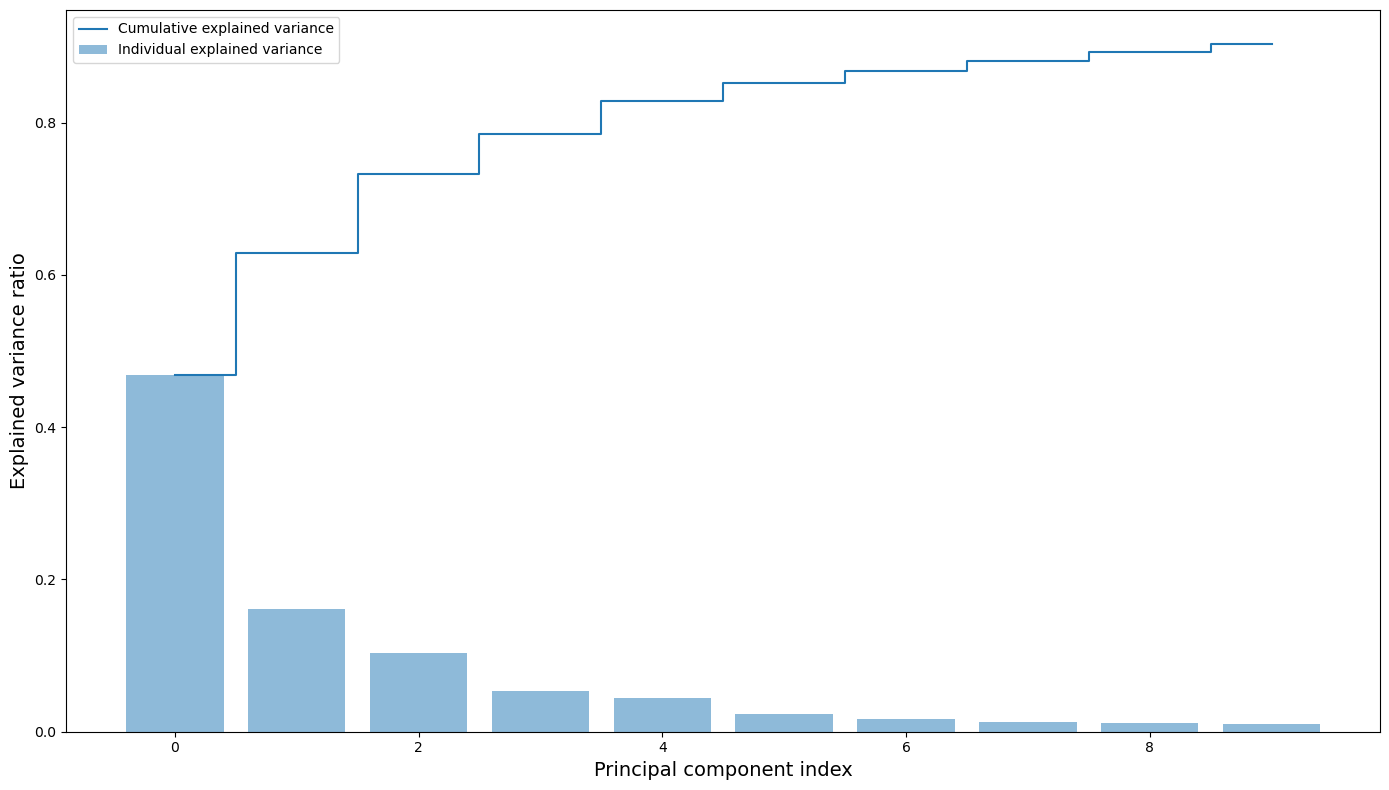

In [1303]:
plt.figure(figsize = (14, 8))

plt.bar(range(0,len(pipe.named_steps.pca.explained_variance_ratio_)), pipe.named_steps.pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(np.cumsum(pipe.named_steps.pca.explained_variance_ratio_))), np.cumsum(pipe.named_steps.pca.explained_variance_ratio_), where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio', fontsize = 14)
plt.xlabel('Principal component index', fontsize = 14)
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

- 3 variables can explain about 80% of the total variance.
- That is, PCA variables can reduce the number of variables without significant loss of information.

- Let's check 2 PC variables.

In [1304]:
pipe = Pipeline([
    ('scale',StandardScaler()),
    ('pca', PCA(n_components = 2, random_state = 42)),
])

In [1305]:
res = pipe.fit_transform(df_player_grouped_num_attr)

In [1306]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar', width = 0.75)
    ax.set_ylabel("Feature Weights", fontsize = 15) 
    ax.set_xticklabels(dimensions, rotation = 0, fontsize = 15)
    ax.legend(bbox_to_anchor = (1.2, 1), loc = 'upper right')

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev), fontsize = 15)
    
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

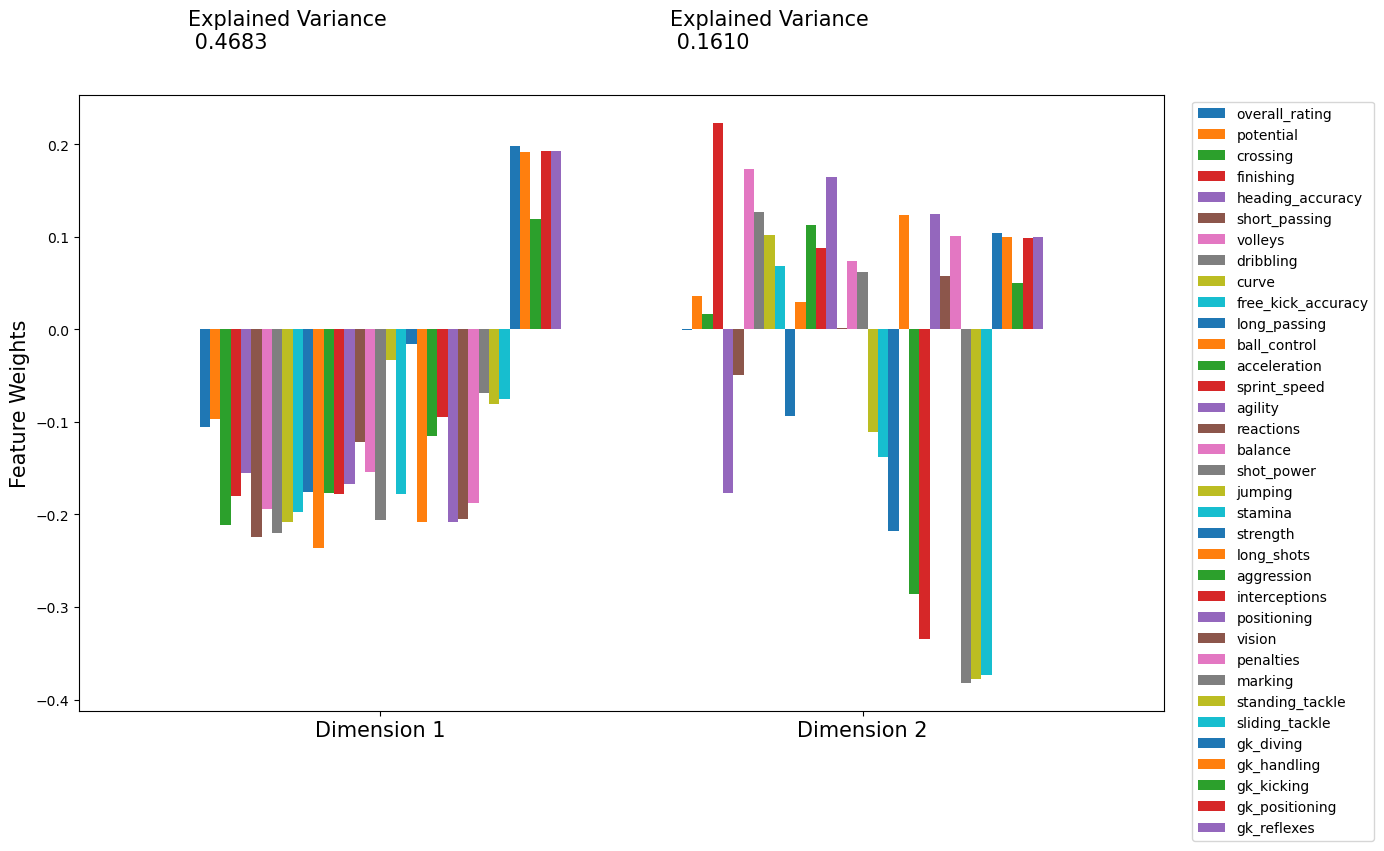

In [1307]:
_ = pca_results(df_player_grouped_num_attr, pipe.named_steps.pca)


- Looking at the feature weights,
    - PC1: All weights related to the golkeeper are positive and all other weights are negative. So PC1 is related to the golkeeper skills.
    - PC2: Weights related to the defense have high absolute values. So PC2 is related to the defense skills.

- Since our goal is to reduce the numerical attributes variables without significant loss of information, let's just use 2 PC variables for each player.
- So for each match, we reduced from 22 players * 35 attributes = 770 columns to 22 players * 2 PC = 44 columns.

In [1308]:
cols = df_player_grouped_num_attr.columns.tolist()
cols.append("player_api_id")
cols.append("date")

In [1309]:
df_num_attr_pc  = pipe.fit_transform(df_player_all_imputed[cols].set_index(["player_api_id", "date"]))

In [1310]:
df_num_attr_pc = pd.DataFrame(df_num_attr_pc, columns = ["PC1", "PC2"], 
                              index = df_player_all_imputed[cols].set_index(["player_api_id", "date"]).index).reset_index()
df_num_attr_pc

,player_api_id,date,PC1,PC2
0,505942,2016-02-18 00:00:00,1.047109,2.688474
1,505942,2015-11-19 00:00:00,1.047109,2.688474
2,505942,2015-09-21 00:00:00,1.400203,2.037032
3,505942,2015-03-20 00:00:00,1.615613,1.927880
4,505942,2007-02-22 00:00:00,1.615613,1.927880
...,...,...,...,...
183137,39902,2009-08-30 00:00:00,-4.991673,-2.921667
183138,39902,2009-02-22 00:00:00,-3.766184,-2.749917
183139,39902,2008-08-30 00:00:00,-3.744909,-2.589794
183140,39902,2007-08-30 00:00:00,-3.382323,-2.497600


### Modeling

- Let's predict the match result only by the 22 player's PC variables.

In [1311]:
df_match_lineup = df_match[["date", "match_api_id",
                            "home_player_1", "home_player_2", "home_player_3", "home_player_4", 
                            "home_player_5", "home_player_6", "home_player_7", "home_player_8",
                            "home_player_9", "home_player_10", "home_player_11", 
                            "away_player_1", "away_player_2", "away_player_3", "away_player_4", 
                            "away_player_5", "away_player_6", "away_player_7", "away_player_8",
                            "away_player_9", "away_player_10", "away_player_11"]]

<AxesSubplot:>

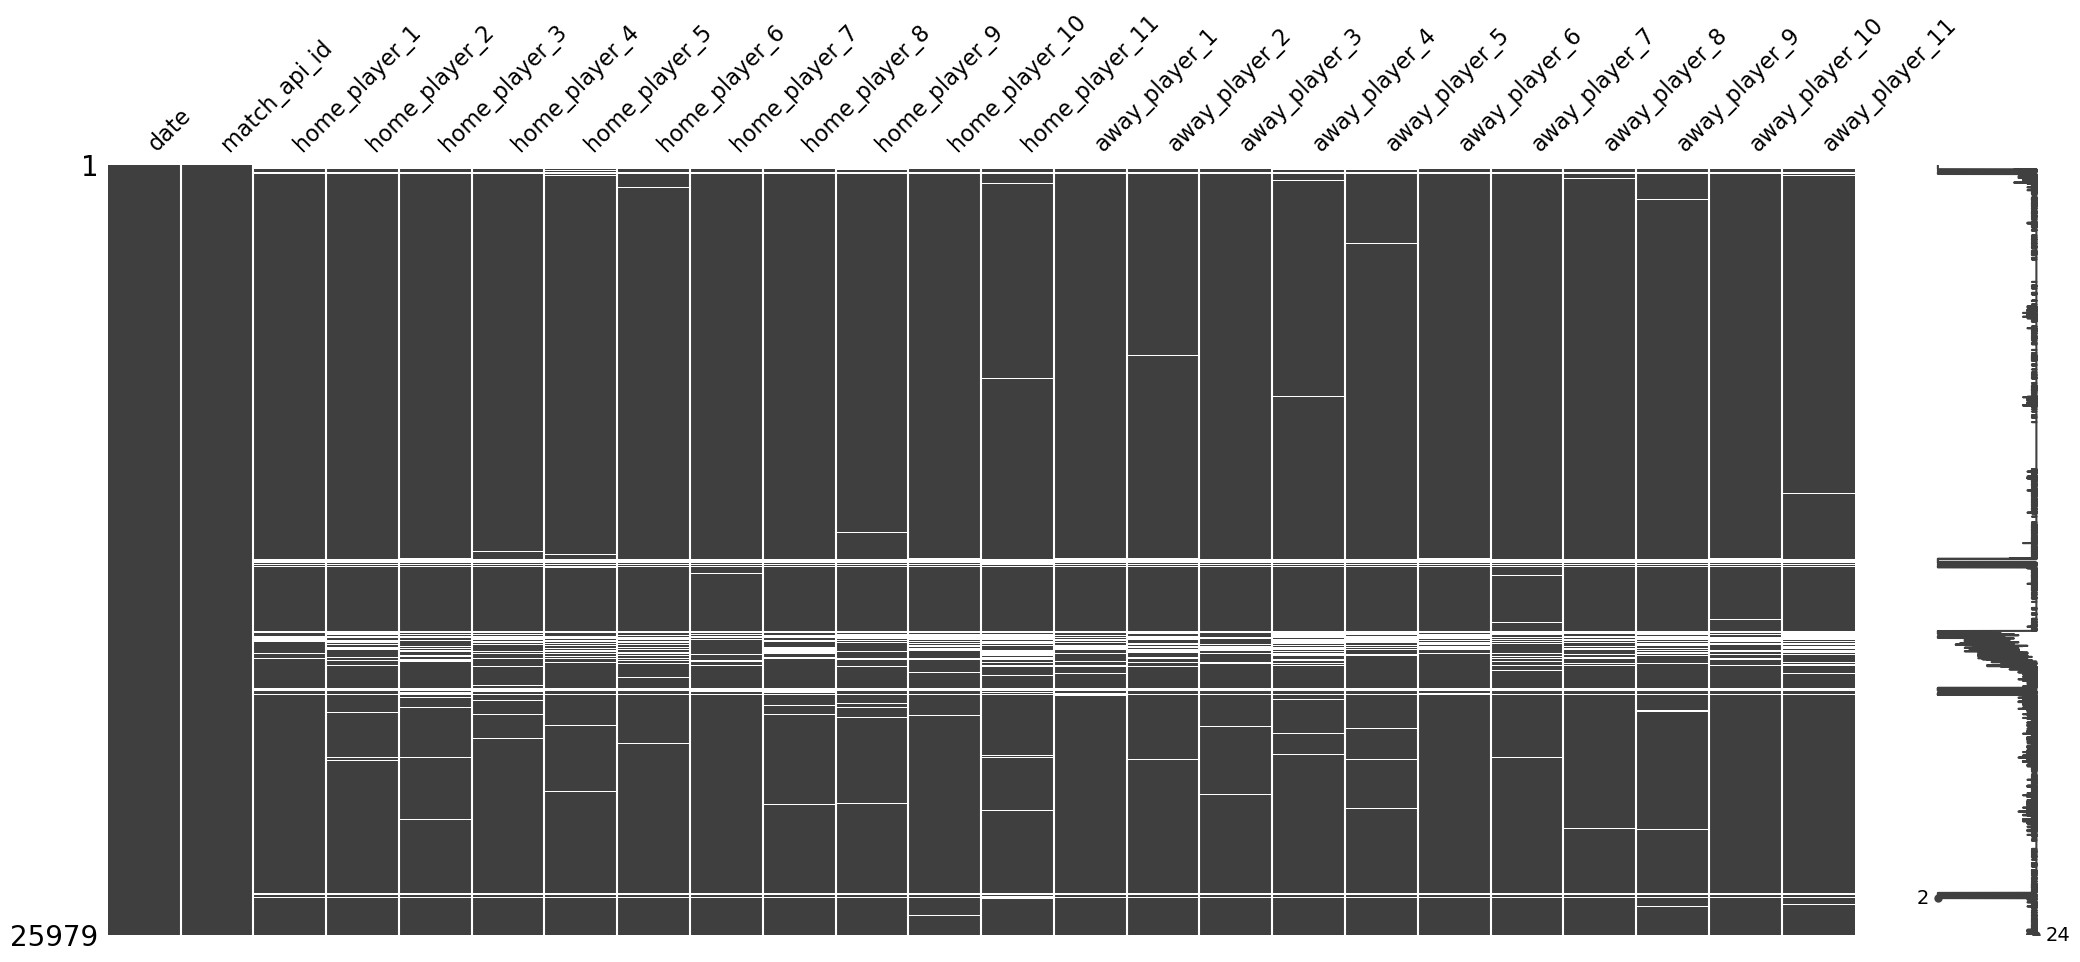

In [1312]:
msno.matrix(df_match_lineup)

- If there is at least one missing value in the starting lineup, let's exclude the match from the analysis.

In [1313]:
df_match_lineup = df_match_lineup.dropna()

- Also, let's exclude the matches where all betting information are mssing.

In [1314]:
df_match_lineup = df_match_lineup[df_match_lineup.match_api_id.isin(df_betting_stat.match_api_id)]

In [1315]:
df_match_lineup.shape

(19691, 24)

- There are total 19,691 matches.

- Change the match date to the datetime format

In [1316]:
df_match_lineup["date"] = pd.to_datetime(df_match_lineup.date).dt.strftime("%Y-%m-%d")
df_match_lineup.head()

,date,match_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
145,2009-02-27,493017,38327.0,67950.0,67958.0,67959.0,37112.0,36393.0,148286.0,67898.0,164352.0,38801.0,26502.0,37937.0,38293.0,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0
153,2009-03-08,493025,36835.0,37047.0,37021.0,37051.0,104386.0,32863.0,37957.0,37909.0,38357.0,37065.0,78462.0,37990.0,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0
155,2009-03-07,493027,34480.0,38388.0,26458.0,13423.0,38389.0,30949.0,38393.0,38253.0,38383.0,38778.0,37069.0,37900.0,37886.0,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0
162,2009-03-13,493034,38327.0,67950.0,67958.0,38801.0,67898.0,37112.0,67959.0,148286.0,164352.0,33657.0,26502.0,34480.0,38388.0,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0
168,2009-03-14,493040,37900.0,37886.0,37100.0,37903.0,37889.0,37893.0,37981.0,131531.0,131530.0,38231.0,130027.0,38318.0,38247.0,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0


In [1317]:
df_num_attr_pc["player_attr_date"] = pd.to_datetime(df_num_attr_pc.date).dt.strftime("%Y-%m-%d")
df_num_attr_pc = df_num_attr_pc.drop("date", axis = 1)
df_num_attr_pc.head()

,player_api_id,PC1,PC2,player_attr_date
0,505942,1.047109,2.688474,2016-02-18
1,505942,1.047109,2.688474,2015-11-19
2,505942,1.400203,2.037032,2015-09-21
3,505942,1.615613,1.927880,2015-03-20
4,505942,1.615613,1.927880,2007-02-22


- Use the pc variables measured closest to the match date for each player.

In [1318]:
df_all = df_match_lineup[["match_api_id"]]

In [1319]:
for i, col in enumerate(["home_player_1", "home_player_2", "home_player_3", "home_player_4", 
            "home_player_5", "home_player_6", "home_player_7", "home_player_8",
            "home_player_9", "home_player_10", "home_player_11"]):
    
        merged = df_match_lineup[["date", "match_api_id", col]].merge(df_num_attr_pc,
                                                  how = "left", left_on = col,  right_on = "player_api_id") \
                                                  .sort_values(["player_api_id", "date", "player_attr_date"])      
                                                  
        merged["date_diff"] = (pd.to_datetime(merged.player_attr_date) - pd.to_datetime(merged.date)).dt.days
        merged = merged[merged.date_diff < 0]
        merged_get_first = merged.sort_values(["player_api_id", "date", "date_diff"], ascending = [True, True, False]).groupby(["player_api_id", "date"]).first()
        merged_get_first = merged_get_first[["match_api_id", "PC1", "PC2"]].rename(columns = {"PC1": f"home_player_{i + 1}_pc_1", 
                                                                                              "PC2": f"home_player_{i + 1}_pc_2"})
        
        
        df_all = df_all.merge(merged_get_first, how = "left", on = "match_api_id")

In [1320]:
for i, col in enumerate(["away_player_1", "away_player_2", "away_player_3", "away_player_4", 
            "away_player_5", "away_player_6", "away_player_7", "away_player_8",
            "away_player_9", "away_player_10", "away_player_11"]):
    
        merged = df_match_lineup[["date", "match_api_id", col]].merge(df_num_attr_pc,
                                                  how = "left", left_on = col,  right_on = "player_api_id") \
                                                  .sort_values(["player_api_id", "date", "player_attr_date"])      
                                                  
        merged["date_diff"] = (pd.to_datetime(merged.player_attr_date) - pd.to_datetime(merged.date)).dt.days
        merged = merged[merged.date_diff < 0]
        merged_get_first = merged.sort_values(["player_api_id", "date", "date_diff"], ascending = [True, True, False]).groupby(["player_api_id", "date"]).first()
        merged_get_first = merged_get_first[["match_api_id", "PC1", "PC2"]].rename(columns = {"PC1": f"away_player_{i + 1}_pc_1", 
                                                                                              "PC2": f"away_player_{i + 1}_pc_2"})
        
        
        df_all = df_all.merge(merged_get_first, how = "left", on = "match_api_id")

In [1321]:
df_all 

,match_api_id,home_player_1_pc_1,home_player_1_pc_2,home_player_2_pc_1,home_player_2_pc_2,home_player_3_pc_1,home_player_3_pc_2,home_player_4_pc_1,home_player_4_pc_2,home_player_5_pc_1,home_player_5_pc_2,home_player_6_pc_1,home_player_6_pc_2,home_player_7_pc_1,home_player_7_pc_2,home_player_8_pc_1,home_player_8_pc_2,home_player_9_pc_1,home_player_9_pc_2,home_player_10_pc_1,home_player_10_pc_2,home_player_11_pc_1,home_player_11_pc_2,away_player_1_pc_1,away_player_1_pc_2,away_player_2_pc_1,away_player_2_pc_2,away_player_3_pc_1,away_player_3_pc_2,away_player_4_pc_1,away_player_4_pc_2,away_player_5_pc_1,away_player_5_pc_2,away_player_6_pc_1,away_player_6_pc_2,away_player_7_pc_1,away_player_7_pc_2,away_player_8_pc_1,away_player_8_pc_2,away_player_9_pc_1,away_player_9_pc_2,away_player_10_pc_1,away_player_10_pc_2,away_player_11_pc_1,away_player_11_pc_2
0,493017,9.173127,-0.705373,3.958011,1.651289,-0.817482,-0.589486,3.108932,0.633919,0.615451,-0.611880,-0.042448,-0.553702,1.086321,-2.583386,-0.845660,-0.053602,4.244826,1.088336,-0.559253,1.233342,1.472469,-0.298079,9.794832,-0.549044,-1.886621,1.005774,1.320326,1.065330,2.628613,0.940820,3.208124,0.685438,-1.360117,-2.980054,-1.734845,-0.323783,-0.004035,1.646115,-1.836425,-2.551944,-0.916613,-1.202178,0.628878,-1.750996
1,493025,6.467934,-2.125161,0.390818,1.341653,2.673586,1.688953,0.544930,0.856705,0.349709,-0.322415,-2.997587,-1.279381,-1.262225,0.290658,-1.035670,-0.034412,-1.969921,-1.958978,-1.205973,-2.567236,-0.417247,-0.845265,6.746251,-1.225526,-0.720506,1.362789,1.321648,2.234328,-1.156961,1.181285,-1.573148,0.366264,-2.362001,0.960853,-2.036508,1.423170,-1.002729,-2.335544,-1.407718,-2.205453,-2.259488,-2.778254,0.169164,-2.319111
2,493027,7.588132,-0.669727,-0.658987,2.447208,0.782712,2.059492,0.750844,3.078352,0.361974,2.339319,-3.759171,1.203933,-3.018022,0.545243,-2.589616,0.570799,-3.859235,-1.870870,-0.199504,-2.415767,-1.056623,-1.205966,8.943077,-2.146684,0.326199,1.666858,1.716927,1.133790,1.823006,1.126495,5.022029,0.646335,0.882918,1.703759,-0.779940,-0.700815,-0.691489,-2.016360,1.464672,0.379542,1.923373,-2.893446,0.417110,-2.210444
3,493034,9.173127,-0.705373,3.958011,1.651289,-0.817482,-0.589486,-0.559253,1.233342,-0.845660,-0.053602,0.615451,-0.611880,3.108932,0.633919,1.086321,-2.583386,4.244826,1.088336,-0.105532,0.211942,1.472469,-0.298079,7.588132,-0.669727,-0.658987,2.447208,0.361974,2.339319,1.052216,2.080874,2.077163,1.903516,-3.759171,1.203933,-0.631175,-1.917264,-3.859235,-1.870870,-3.018022,0.545243,-2.589616,0.570799,-1.056623,-1.205966
4,493040,8.943077,-2.146684,0.326199,1.666858,1.831588,1.436229,1.716927,1.133790,1.823006,1.126495,0.882918,1.703759,-0.779940,-0.700815,-0.691489,-2.016360,0.417110,-2.210444,1.923373,-2.893446,1.464672,0.379542,9.534301,-0.799900,1.976167,1.867884,4.479321,2.454178,1.829738,1.080162,4.019637,0.341615,0.672027,0.212298,-0.845349,-0.770479,1.941371,0.896069,-0.202958,-1.625013,0.323927,-3.293479,0.818024,-2.420730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19686,2030167,11.269098,-2.363261,-4.269665,1.775026,0.626189,4.830156,-2.147631,4.492998,-4.836437,2.084446,-5.144059,0.994393,-4.329497,1.743412,-5.542764,-0.919336,-4.431408,-4.501227,-4.823456,-1.183391,-5.526190,-3.645511,11.658194,-2.511555,-3.210408,1.074591,-2.169579,3.556340,0.283695,4.490128,-4.691037,1.302024,-5.777413,-0.212881,-5.323438,1.501037,-3.559741,2.554507,-4.357977,1.392411,-4.627439,-2.863982,-2.640033,-2.522352
19687,2030168,11.854144,-2.386507,-3.677980,1.073062,2.092008,4.374282,1.115249,4.907132,-4.009042,1.456494,-3.444074,1.569526,-3.319146,1.198255,-3.791117,-3.158982,-3.369560,-0.760560,-3.560261,0.516589,-2.689566,-2.523845,12.229593,-1.892454,-3.463575,1.258055,1.399754,4.503143,-0.073918,4.004479,-2.210266,3.190800,-3.864425,-1.563232,-4.161120,0.968391,-2.951303,1.126863,-3.607998,-3.0

In [1322]:
y = df_match.merge(df_league.rename(columns = {"name" : "league"}), how = "left", on = "country_id") \
            .merge(df_match_result, how = "left", on = ["league", "season", "stage", "home_team_api_id", "away_team_api_id"]) \
            [["match_api_id", "match_result"]]
y

,match_api_id,match_result
0,492473,draw
1,492474,draw
2,492475,away_win
3,492476,home_win
4,492477,away_win
...,...,...
25974,1992091,home_win
25975,1992092,away_win
25976,1992093,home_win
25977,1992094,draw


In [1323]:
df_all = df_all.merge(y, how = "left", on = "match_api_id")

In [1324]:
df_all = df_all.merge(df_betting_stat, how = "left", on = "match_api_id")

In [1325]:
df_all = df_all.set_index("match_api_id")
df_all

,home_player_1_pc_1,home_player_1_pc_2,home_player_2_pc_1,home_player_2_pc_2,home_player_3_pc_1,home_player_3_pc_2,home_player_4_pc_1,home_player_4_pc_2,home_player_5_pc_1,home_player_5_pc_2,home_player_6_pc_1,home_player_6_pc_2,home_player_7_pc_1,home_player_7_pc_2,home_player_8_pc_1,home_player_8_pc_2,home_player_9_pc_1,home_player_9_pc_2,home_player_10_pc_1,home_player_10_pc_2,home_player_11_pc_1,home_player_11_pc_2,away_player_1_pc_1,away_player_1_pc_2,away_player_2_pc_1,away_player_2_pc_2,away_player_3_pc_1,away_player_3_pc_2,away_player_4_pc_1,away_player_4_pc_2,away_player_5_pc_1,away_player_5_pc_2,away_player_6_pc_1,away_player_6_pc_2,away_player_7_pc_1,away_player_7_pc_2,away_player_8_pc_1,away_player_8_pc_2,away_player_9_pc_1,away_player_9_pc_2,away_player_10_pc_1,away_player_10_pc_2,away_player_11_pc_1,away_player_11_pc_2,match_result,H_odd_min,H_odd_max,H_odd_mean,H_odd_std,D_odd_min,D_odd_max,D_odd_mean,D_odd_std,A_odd_min,A_odd_max,A_odd_mean,A_odd_std
match_api_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
493017,9.173127,-0.705373,3.958011,1.651289,-0.817482,-0.589486,3.108932,0.633919,0.615451,-0.611880,-0.042448,-0.553702,1.086321,-2.583386,-0.845660,-0.053602,4.244826,1.088336,-0.559253,1.233342,1.472469,-0.298079,9.794832,-0.549044,-1.886621,1.005774,1.320326,1.065330,2.628613,0.940820,3.208124,0.685438,-1.360117,-2.980054,-1.734845,-0.323783,-0.004035,1.646115,-1.836425,-2.551944,-0.916613,-1.202178,0.628878,-1.750996,home_win,2.62,3.00,2.795000,2.62,3.10,3.40,3.241667,3.10,2.20,2.35,2.258333,2.20
493025,6.467934,-2.125161,0.390818,1.341653,2.673586,1.688953,0.544930,0.856705,0.349709,-0.322415,-2.997587,-1.279381,-1.262225,0.290658,-1.035670,-0.034412,-1.969921,-1.958978,-1.205973,-2.567236,-0.417247,-0.845265,6.746251,-1.225526,-0.720506,1.362789,1.321648,2.234328,-1.156961,1.181285,-1.573148,0.366264,-2.362001,0.960853,-2.036508,1.423170,-1.002729,-2.335544,-1.407718,-2.205453,-2.259488,-2.778254,0.169164,-2.319111,away_win,2.65,3.20,2.958333,2.65,3.00,3.20,3.150000,3.00,2.00,2.37,2.186667,2.00
493027,7.588132,-0.669727,-0.658987,2.447208,0.782712,2.059492,0.750844,3.078352,0.361974,2.339319,-3.759171,1.203933,-3.018022,0.545243,-2.589616,0.570799,-3.859235,-1.870870,-0.199504,-2.415767,-1.056623,-1.205966,8.943077,-2.146684,0.326199,1.666858,1.716927,1.133790,1.823006,1.126495,5.022029,0.646335,0.882918,1.703759,-0.779940,-0.700815,-0.691489,-2.016360,1.464672,0.379542,1.923373,-2.893446,0.417110,-2.210444,home_win,1.30,1.40,1.353333,1.30,4.00,4.50,4.141667,4.00,7.00,9.00,7.666667,7.00
493034,9.173127,-0.705373,3.958011,1.651289,-0.817482,-0.589486,-0.559253,1.233342,-0.845660,-0.053602,0.615451,-0.611880,3.108932,0.633919,1.086321,-2.583386,4.244826,1.088336,-0.105532,0.211942,1.472469,-0.298079,7.588132,-0.669727,-0.658987,2.447208,0.361974,2.339319,1.052216,2.080874,2.077163,1.903516,-3.759171,1.203933,-0.631175,-1.917264,-3.859235,-1.870870,-3.018022,0.545243,-2.589616,0.570799,-1.056623,-1.205966,home_win,4.00,4.70,4.346667,4.00,3.20,3.60,3.350000,3.20,1.70,1.75,1.720000,1.70
493040,8.943077,-2.146684,0.326199,1.666858,1.831588,1.436229,1.716927,1.133790,1.823006,1.126495,0.882918,1.703759,-0.779940,-0.700815,-0.691489,-2.016360,0.417110,-2.210444,1.923373,-2.893446,1.464672,0.379542,9.534301,-0.799900,1.976167,1.867884,4.479321,2.454178,1.829738,1.080162,4.019637,0.341615,0.672027,0.212298,-0.845349,-0.770479,1.941371,0.896069,-0.202958,-1.625013,0.323927,-3.293479,0.818024,-2.420730,draw,1.60,1.75,1.655000,1.60,3.25,3.55,3.433333,3.25,4.20,5.05,4.638333,4.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030167,11.269098,-2.363261,-4.269665,1.775026,0.626189,4.830156,-2.147631,4.492998,-4.836437,2.084446,-5.144059,0.994393,-4.329497,1.743412,-5.542764,-0.919336,-4.431408,-4.501227,-4.823456,-1.18339

- Split the data into train, test set. Test set are matches from the season 2015/2016.

In [1326]:
train_bool = df_all.reset_index().match_api_id.isin(train_match_api_id)

In [1327]:
df_all_train = df_all.reset_index()[train_bool].set_index("match_api_id")
df_all_test = df_all.reset_index()[~train_bool].set_index("match_api_id")

In [1328]:
X_all_train = df_all_train.drop("match_result", axis = 1)
y_train = df_all_train.match_result 

X_all_test = df_all_test.drop("match_result", axis = 1)
y_test = df_all_test.match_result

In [1329]:
print("Number of train data: ", X_all_train.shape[0])
print("Number of test data: ", X_all_test.shape[0])

Number of train data:  17029
Number of test data:  2662


- Seperate player pc variables and the betting stat variables and only train the player pc variables.

In [1330]:
player_pc_columns = ['home_player_1_pc_1', 'home_player_1_pc_2',
                     'home_player_2_pc_1', 'home_player_2_pc_2', 'home_player_3_pc_1',
                     'home_player_3_pc_2', 'home_player_4_pc_1', 'home_player_4_pc_2',
                     'home_player_5_pc_1', 'home_player_5_pc_2', 'home_player_6_pc_1',
                     'home_player_6_pc_2', 'home_player_7_pc_1', 'home_player_7_pc_2',
                     'home_player_8_pc_1', 'home_player_8_pc_2', 'home_player_9_pc_1',
                     'home_player_9_pc_2', 'home_player_10_pc_1', 'home_player_10_pc_2',
                     'home_player_11_pc_1', 'home_player_11_pc_2', 'away_player_1_pc_1',
                     'away_player_1_pc_2', 'away_player_2_pc_1', 'away_player_2_pc_2',
                     'away_player_3_pc_1', 'away_player_3_pc_2', 'away_player_4_pc_1',
                     'away_player_4_pc_2', 'away_player_5_pc_1', 'away_player_5_pc_2',
                     'away_player_6_pc_1', 'away_player_6_pc_2', 'away_player_7_pc_1',
                     'away_player_7_pc_2', 'away_player_8_pc_1', 'away_player_8_pc_2',
                     'away_player_9_pc_1', 'away_player_9_pc_2', 'away_player_10_pc_1',
                     'away_player_10_pc_2', 'away_player_11_pc_1', 'away_player_11_pc_2']


X_player_pc_train = X_all_train[player_pc_columns]
X_player_pc_test = X_all_test[player_pc_columns]


In [1331]:
names = ["KNN", 
         "LDA", 
         "QDA", 
         "Naive Bayes",
         "Logistic regression",
         "Decesion tree", 
         "Random Forest",  
         "AdaBoost",
         "Polynomial kernel SVM",
         "Radial kernel SVM"
        ]

classifiers = [
    KNeighborsClassifier(3),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(), 
    LogisticRegression(),
    DecisionTreeClassifier(random_state = 42),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    SVC(kernel = "poly"),
    SVC(kernel = "rbf")
    ]

In [1354]:
result_accuracy = pd.DataFrame(names, columns = ["model_name"])

In [1355]:
y_pred_dict = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_player_pc_train, y_train)
    
    y_pred = clf.predict(X_player_pc_test)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Player PC Variables"] = round(accuracy * 100, 3)

In [1356]:
result_accuracy

,model_name,Player PC Variables
0,KNN,43.276
1,LDA,50.188
2,QDA,46.882
3,Naive Bayes,47.446
4,Logistic regression,50.000
5,Decesion tree,36.814
6,Random Forest,49.925
7,AdaBoost,49.925
8,Polynomial kernel SVM,50.413
9,Radial kernel SVM,50.488


- Without any hyperparameter tuning, polynomial kernel svm, radial kernel svm, and LDA have little bit higher accuracy than other models.

## 3.2 Variable set 2: betting information columns

In [1337]:
betting_stat_columns = ['H_odd_min', 'H_odd_max', 'H_odd_mean', 'H_odd_std', 
                        'D_odd_min', 'D_odd_max', 'D_odd_mean', 'D_odd_std', 
                        'A_odd_min', 'A_odd_max', 'A_odd_mean', 'A_odd_std']

In [1338]:
X_betting_train = X_all_train[betting_stat_columns]
X_betting_test = X_all_test[betting_stat_columns]

- Standardize the betting stat columns.

In [1341]:
std_scaler = StandardScaler()

std_scaler.fit(X_betting_train)
X_betting_train_std = std_scaler.transform(X_betting_train)
X_betting_test_std = std_scaler.transform(X_betting_test)

In [1357]:
y_pred_dict = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_betting_train_std, y_train)
    
    y_pred = clf.predict(X_betting_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Betting Statistics Variables"] = round(accuracy * 100, 3)

In [1358]:
result_accuracy

,model_name,Player PC Variables,Betting Statistics Variables
0,KNN,43.276,44.140
1,LDA,50.188,51.503
2,QDA,46.882,39.031
3,Naive Bayes,47.446,41.998
4,Logistic regression,50.000,51.653
5,Decesion tree,36.814,42.149
6,Random Forest,49.925,48.347
7,AdaBoost,49.925,51.653
8,Polynomial kernel SVM,50.413,48.760
9,Radial kernel SVM,50.488,51.503


- The QDA model is less accurate when using the betting statistc variables, and the decision tree model is less accurate when using the player PC variables.
- All other models showed little difference in accuracy between the two variables.

## 3.3. Variable set 3: team attributes columns (will do later)

- Will do later

## 3.4. Variable set 4: in-game information columns (will do later)

- Will do later

## 3.5. All variables

- Let's use all variables to predict the match result.

In [1348]:
X_all_train_std = pd.concat([X_player_pc_train, 
                             pd.DataFrame(X_betting_train_std, columns = X_betting_train.columns, 
                                          index = X_betting_train.index)], axis = 1)
X_all_test_std = pd.concat([X_player_pc_test, 
                            pd.DataFrame(X_betting_test_std, columns = X_betting_test.columns, 
                                          index = X_betting_test.index)], axis = 1)

In [1359]:
y_pred_dict = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_all_train_std, y_train)
    
    y_pred = clf.predict(X_all_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "All Variables"] = round(accuracy * 100, 3)

In [1360]:
result_accuracy

,model_name,Player PC Variables,Betting Statistics Variables,All Variables
0,KNN,43.276,44.140,44.929
1,LDA,50.188,51.503,51.803
2,QDA,46.882,39.031,44.215
3,Naive Bayes,47.446,41.998,42.863
4,Logistic regression,50.000,51.653,51.766
5,Decesion tree,36.814,42.149,39.256
6,Random Forest,49.925,48.347,51.465
7,AdaBoost,49.925,51.653,51.728
8,Polynomial kernel SVM,50.413,48.760,51.089
9,Radial kernel SVM,50.488,51.503,51.052


- When all variables are used, the accuracy tends to increase slightly.

## 3.6. Hyperparameter tunning

- Now let's tune the several models:
    - LDA
    - Random Forest	
    - AdaBoost
    - Polynomial kernel SVM
    - Radial kernel SVM

### LDA

In [1384]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import pprint
from scipy import stats
from IPython.display import display

def plot_grid_search(clf):
    """Plot as many graphs as parameters are in the grid search results.

    Each graph has the values of each parameter in the X axis and the Score in the Y axis.

    Parameters
    ----------
    clf: estimator object result of a GridSearchCV
        This object contains all the information of the cross validated results for all the parameters combinations.
    """
    # Convert the cross validated results in a DataFrame ordered by `rank_test_score` and `mean_fit_time`.
    # As it is frequent to have more than one combination with the same max score,
    # the one with the least mean fit time SHALL appear first.
    cv_results = pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score', 'mean_fit_time'])

    # Get parameters
    parameters=cv_results['params'][0].keys()

    # Calculate the number of rows and columns necessary
    rows = -(-len(parameters) // 2)
    columns = min(len(parameters), 2)
    # Create the subplot
    fig = make_subplots(rows=rows, cols=columns)
    # Initialize row and column indexes
    row = 1
    column = 1

    # For each of the parameters
    for parameter in parameters:

        # As all the graphs have the same traces, and by default all traces are shown in the legend,
        # the description appears multiple times. Then, only show legend of the first graph.
        if row == 1 and column == 1:
            show_legend = True
        else:
            show_legend = False

        # Mean test score
        mean_test_score = cv_results[cv_results['rank_test_score'] != 1]
        fig.add_trace(go.Scatter(
            name='Mean test score',
            x=mean_test_score['param_' + parameter],
            y=mean_test_score['mean_test_score'],
            mode='markers',
            marker=dict(size=mean_test_score['mean_fit_time'],
                        color='SteelBlue',
                        sizeref=2. * cv_results['mean_fit_time'].max() / (40. ** 2),
                        sizemin=4,
                        sizemode='area'),
            text=mean_test_score['params'].apply(
                lambda x: pprint.pformat(x, width=-1).replace('{', '').replace('}', '').replace('\n', '<br />')),
            showlegend=show_legend),
            row=row,
            col=column)

        # Best estimators
        rank_1 = cv_results[cv_results['rank_test_score'] == 1]
        fig.add_trace(go.Scatter(
            name='Best estimators',
            x=rank_1['param_' + parameter],
            y=rank_1['mean_test_score'],
            mode='markers',
            marker=dict(size=rank_1['mean_fit_time'],
                        color='Crimson',
                        sizeref=2. * cv_results['mean_fit_time'].max() / (40. ** 2),
                        sizemin=4,
                        sizemode='area'),
            text=rank_1['params'].apply(str),
            showlegend=show_legend),
            row=row,
            col=column)

        fig.update_xaxes(title_text=parameter, row=row, col=column)
        fig.update_yaxes(title_text='Score', row=row, col=column)

        # Check the linearity of the series
        # Only for numeric series
        if pd.to_numeric(cv_results['param_' + parameter], errors='coerce').notnull().all():
            x_values = cv_results['param_' + parameter].sort_values().unique().tolist()
            r = stats.linregress(x_values, range(0, len(x_values))).rvalue
            # If not so linear, then represent the data as logarithmic
            if r < 0.86:
                fig.update_xaxes(type='log', row=row, col=column)

        # Increment the row and column indexes
        column += 1
        if column > columns:
            column = 1
            row += 1

            # Show first the best estimators
    fig.update_layout(legend=dict(traceorder='reversed'),
                      width=columns * 360 + 100,
                      height=rows * 360,
                      title='Best score: {:.6f} with {}'.format(cv_results['mean_test_score'].iloc[0],
                                                                str(cv_results['params'].iloc[0]).replace('{',
                                                                                                          '').replace(
                                                                    '}', '')),
                      hovermode='closest',
                      template='none')
    fig.show()


def table_grid_search(clf, all_columns=False, all_ranks=False, save=True):
    """Show tables with the grid search results.

    Parameters
    ----------
    clf: estimator object result of a GridSearchCV
        This object contains all the information of the cross validated results for all the parameters combinations.

    all_columns: boolean, default: False
        If true all columns are returned. If false, the following columns are dropped:

        - params. As each parameter has a column with the value.
        - std_*. Standard deviations.
        - split*. Split scores.

    all_ranks: boolean, default: False
        If true all ranks are returned. If false, only the rows with rank equal to 1 are returned.

    save: boolean, default: True
        If true, results are saved to a CSV file.
    """
    # Convert the cross validated results in a DataFrame ordered by `rank_test_score` and `mean_fit_time`.
    # As it is frequent to have more than one combination with the same max score,
    # the one with the least mean fit time SHALL appear first.
    cv_results = pd.DataFrame(clf.cv_results_).sort_values(by=['rank_test_score', 'mean_fit_time'])

    # Reorder
    columns = cv_results.columns.tolist()
    # rank_test_score first, mean_test_score second and std_test_score third
    columns = columns[-1:] + columns[-3:-1] + columns[:-3]
    cv_results = cv_results[columns]

    if save:
        cv_results.to_csv('--'.join(cv_results['params'][0].keys()) + '.csv', index=True, index_label='Id')

    # Unless all_columns are True, drop not wanted columns: params, std_* split*
    if not all_columns:
        cv_results.drop('params', axis='columns', inplace=True)
        cv_results.drop(list(cv_results.filter(regex='^std_.*')), axis='columns', inplace=True)
        cv_results.drop(list(cv_results.filter(regex='^split.*')), axis='columns', inplace=True)

    # Unless all_ranks are True, filter out those rows which have rank equal to one
    if not all_ranks:
        cv_results = cv_results[cv_results['rank_test_score'] == 1]
        cv_results.drop('rank_test_score', axis = 'columns', inplace = True)        
        cv_results = cv_results.style.hide_index()

    display(cv_results)

In [1363]:
param_grid = [{
    "solver": ["svd", "lsqr", "eigen"],
    "shrinkage": np.arange(0, 1, 0.01)
}]

model = LinearDiscriminantAnalysis()

lda_grid = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
lda_grid.fit(X_all_train_std, y_train)

print(lda_grid.best_estimator_)
print(lda_grid.best_score_)

LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr')
0.5273362460476158


In [1376]:
result_accuracy[result_accuracy.model_name == "LDA"]

,model_name,Player PC Variables,Betting Statistics Variables,All Variables
1,LDA,50.188,51.503,51.803


- Best hyperparameter is shrinkage = 0.0, solver = "lsqr"
- Best accuracy is 0.527, slightly higher than before.

### Random Forest

- Check the max_depth

In [1386]:
max_depth_list = range(1, 30)
test_error_list = []

for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth = max_depth)
    
    model.fit(X_all_train_std, y_train)
    y_test_predict = model.predict(X_all_test_std)
    test_error_list.append(np.mean(y_test_predict != y_test))

Text(0.5, 1.0, 'Test error for the different max_depth values')

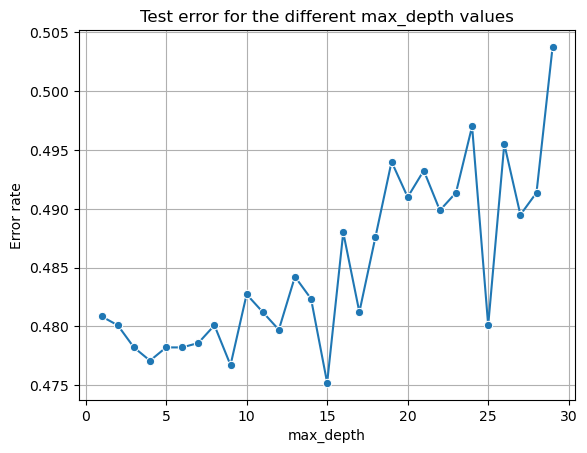

In [1387]:
plt.grid()
sns.lineplot(x = max_depth_list, y = test_error_list, marker = "o")
plt.xlabel("max_depth")
plt.ylabel("Error rate")
plt.title("Test error for the different max_depth values")

- At max_depth = 15, the minimum error is achieved. After max_depth = 15, test error continues to increase.     
-> will fine tune max_depth 1 ~ 15 with other hyperparameters later.

- Check the n_estimators

In [1388]:
n_estimators_list = range(1, 1000, 100)
test_error_list = []

for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators = n_estimators)
    
    model.fit(X_all_train_std, y_train)
    y_test_predict = model.predict(X_all_test_std)
    test_error_list.append(np.mean(y_test_predict != y_test))

Text(0.5, 1.0, 'Test error for the different n_estimators values')

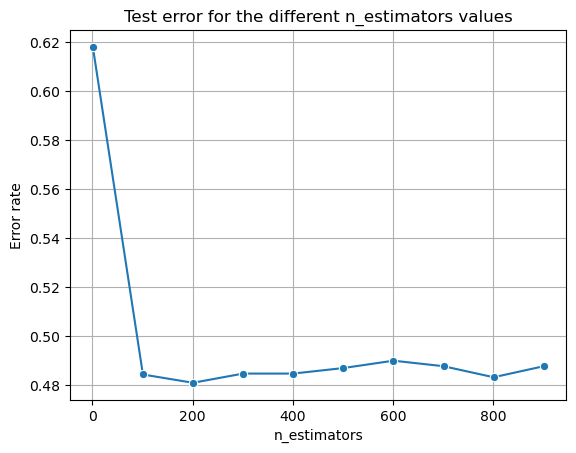

In [1389]:
plt.grid()
sns.lineplot(x = n_estimators_list, y = test_error_list, marker = "o")
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.title("Test error for the different n_estimators values")

- After n_estimators = 200, there is no difference in test error.    
-> So just set n_estimators = 200


- Check the max_features

In [1390]:
max_features_list = range(1, X_all_train_std.shape[1])
test_error_list = []

for max_features in max_features_list:
    model = RandomForestClassifier(max_features = max_features)
    
    model.fit(X_all_train_std, y_train)
    y_test_predict = model.predict(X_all_test_std)
    test_error_list.append(np.mean(y_test_predict != y_test))

In [ ]:
plt.grid()
sns.lineplot(x = max_features_list, y = test_error_list, marker = "o")
plt.xlabel("max_features")
plt.ylabel("Error rate")
plt.title("Test error for the different max_features values")

In [ ]:
parameters = [{
    "max_depth_list": range(1, 16),
    "max_features": max_features_list
    }]

model = RandomForestClassifier(n_estimators = 200)

rf_grid = GridSearchCV(model, parameters, cv = 5, n_jobs = -1)
rf_grid.fit(X_all_train_std, y_train)

print(lda_grid.best_estimator_)
print(lda_grid.best_score_)

### AdaBoost

### Polynomial kernel SVM

### Radial kernel SVM